In [551]:
import numpy as np
import pandas as pd
import datetime
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import catboost as catb
from catboost import Pool
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE


from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
import warnings
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-whitegrid')

In [1079]:
df = pd.read_csv('course_project_train.csv', sep=',')
df_test = pd.read_csv('course_project_test.csv', sep=',')

In [1081]:
df.shape

(7500, 17)

In [1080]:
df_test.shape

(2500, 16)

In [1064]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [272]:
df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

### Целевая переменная:

In [7]:
target_feat = 'Credit Default'
target = df[target_feat]

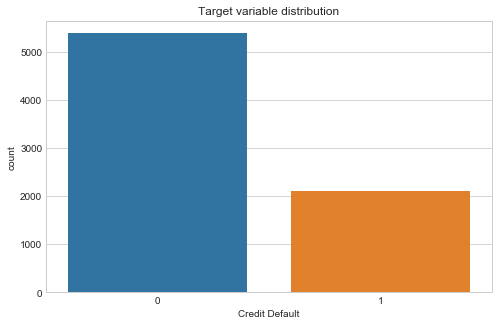

In [8]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_feat, data=df)

plt.title('Target variable distribution')
plt.show()

### Посмотрим на категориальные признаки

In [9]:
def show_few_values(col_lst):    
    for v in col_lst:
        print(df[v].value_counts(), '\n')
        print('Пустых значений:', df[df[v].isnull()].shape[0], '\n')

In [10]:
feauters_with_categories = [
    'Home Ownership',
    'Years in current job',
    'Tax Liens',
    'Number of Credit Problems',
    'Bankruptcies',
    'Purpose',
    'Term',
]
show_few_values(feauters_with_categories)

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64 

Пустых значений: 0 

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64 

Пустых значений: 371 

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64 

Пустых значений: 0 

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64 

Пустых значений: 0 

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64 

Пустых значений: 14 

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills 

### Смотрим корреляцию числовых показателей с целевой переменной

In [161]:
df.corr()

Annual Income  Tax Liens  \
Annual Income                      1.000000   0.066245   
Tax Liens                          0.066245   1.000000   
Number of Open Accounts            0.188524  -0.005360   
Years of Credit History            0.186531   0.009109   
Maximum Open Credit                0.062218  -0.002410   
Number of Credit Problems         -0.015407   0.595339   
Months since last delinquent      -0.101787   0.052446   
Bankruptcies                      -0.066877   0.057360   
Current Loan Amount                0.032082  -0.007835   
Current Credit Balance             0.386481  -0.010195   
Monthly Debt                       0.584819   0.027211   
Credit Score                      -0.037832   0.010581   
Credit Default                    -0.101375   0.024368   
Job_years                          0.104637   0.017723   
Score_level                       -0.037707   0.008623   
Max_open_credit_level              0.119666  -0.009271   

                              Number of Open Accounts  \
Annual Income                                0.188524   
Tax Liens                                   -0.005360   
Number of Open Accounts                      1.000000   
Years of Credit History                      0.144819   
Maximum Open Credit                          0.023897   
Number of Credit Problems                   -0.017813   
Months since last delinquent                -0.032740   
Bankruptcies                                -0.019130   
Current Loan Amount                          0.001346   
Current Credit Balance                       0.267325   
Monthly Debt                                 0.413904   
Credit Score                                 0.016095   
Credit Default                               0.028884   
Job_years                                    0.055124   
Score_level                                  0.014582   
Max_open_credit_level                        0.048184   

                              Years of Credit History  Maximum Open Credit  \
Annual Income                                0.186531             0.062218   
Tax Liens                                    0.009109            -0.002410   
Number of Open Accounts                      0.144819             0.023897   
Years of Credit History                      1.000000             0.029247   
Maximum Open Credit                          0.029247             1.000000   
Number of Credit Problems                    0.071259            -0.004750   
Months since last delinquent                -0.015375            -0.003849   
Bankruptcies                                 0.085699            -0.011650   
Current Loan Amount                          0.010623            -0.002334   
Current Credit Balance                       0.217856             0.088090   
Monthly Debt                                 0.191978             0.010197   
Credit Score                                -0.015683            -0.009136   
Credit Default                              -0.020567            -0.014275   
Job_years                                    0.233286             0.003300   
Score_level                                 -0.016718            -0.005408   
Max_open_credit_level                        0.051138             0.245764   

                              Number of Credit Problems  \
Annual Income                                 -0.015407   
Tax Liens                                      0.595339   
Number of Open Accounts                       -0.017813   
Years of Credit History                        0.071259   
Maximum Open Credit                           -0.004750   
Number of Credit Problems                      1.000000   
Months since last delinquent                   0.139905   
Bankruptcies                                   0.730751   
Current Loan Amount                           -0.008596   
Current Credit Balance                        -0.124137   
Monthly Debt                                  -0.042252   
Credit Score                          

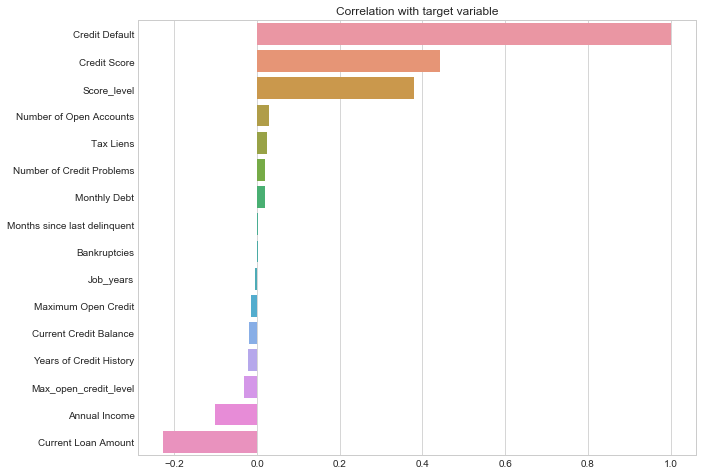

In [164]:
corr_with_target = df.corr().iloc[:, 12].sort_values(ascending=False)
xs = corr_with_target.values
ys = corr_with_target.index

plt.figure(figsize=(10, 8))

sns.barplot(x=xs, y=ys)

plt.title('Correlation with target variable')
plt.show()

### Оценим числовые признаки в связке с целевым признаком

__На графиках ниже видно, что:__
- 'Annual Income' - на вид распределение нормальное и средние совпадают
- 'Number of Open Accounts' - на вид распределение нормальное и средние совпадают
- 'Years of Credit History' - на вид распределение нормальное и средние совпадают

Далее проверим

In [13]:
feauters_with_numbers = [
    'Annual Income',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Months since last delinquent',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score',
]

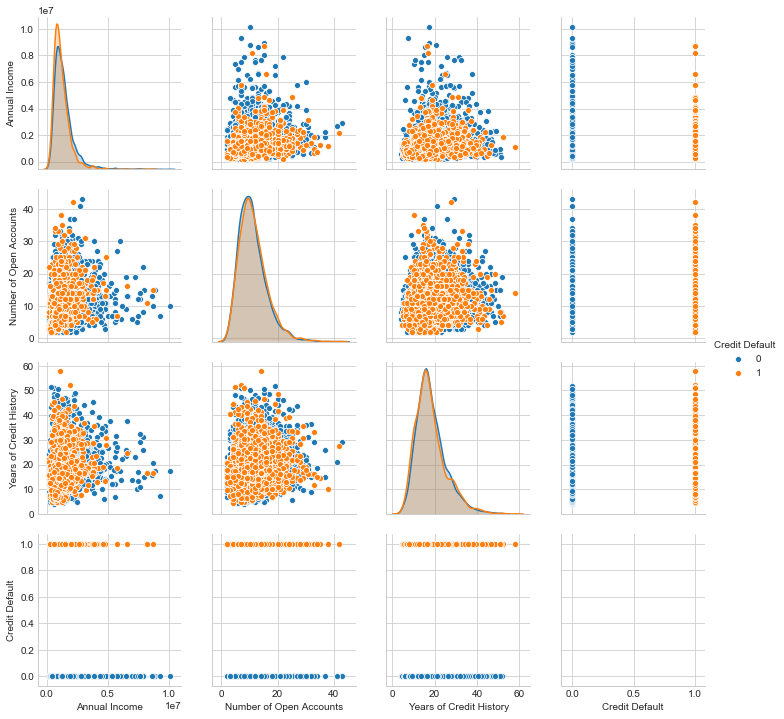

In [14]:
sns_plot = sns.pairplot(df[feauters_with_numbers[0:3] + [target_feat]], hue=target_feat)

__На графиках ниже видно, что:__
- 'Maximum Open Credit' - на вид распределение не нормальное и средние сильно отличаются
- 'Months since last delinquent' - на вид распределение не понятно, средние совпадают
- 'Current Loan Amount' - на вид распределение не нормальное и средние сильно отличаются

Далее проверим

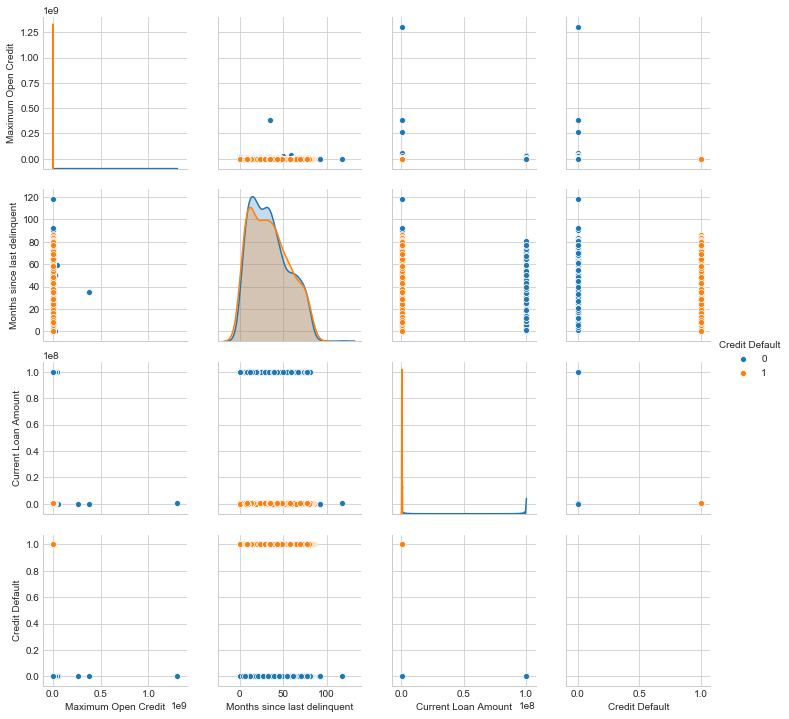

In [15]:
sns_plot = sns.pairplot(df[feauters_with_numbers[3:6] + [target_feat]], hue=target_feat)

__На графиках ниже видно, что:__
- 'Current Credit Balance' - на вид распределение нормальное и средние совпадают
- 'Monthly Debt' - на вид распределение нормальное и средние совпадают
- 'Credit Score' - на вид распределение не нормальное и средние сильно отличаются

Далее проверим

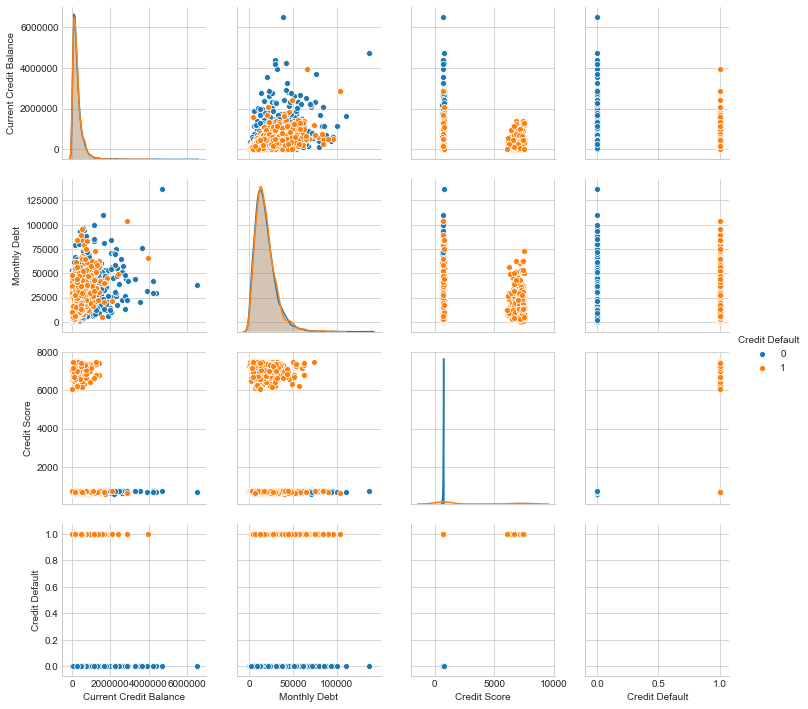

In [16]:
sns_plot = sns.pairplot(df[feauters_with_numbers[6:] + [target_feat]], hue=target_feat)

### Посмотрим на характеристики числовых признаков

In [17]:
def extend_describe_for_num_values(df, col_lst, target_name):
    #Функция возвращает доп.данные по признакам с таблицой describe: 
    # - дисперсию
    # - кол-во пустых значений
    # - корреляцию Пирсона с целевым признаком
    # - p-value по тесту Шапиро о нормальности распределения
    
    df_describe = df[col_lst].describe()
    df_desc_add = pd.DataFrame(columns=col_lst)
    for _ in range(4):
        df_desc_add = df_desc_add.append(pd.Series(), ignore_index=True)
    
    
    for v in col_lst:
        df_desc_add[v].iloc[[0]] = np.var(df[v])
        df_desc_add[v].iloc[[1]] = df[df[v].isnull()].shape[0]
        df_notna = df.loc[df[v].notna()]
        shapiro_p_value = shapiro(df_notna[v])[1]
        df_desc_add[v].iloc[[2]] = shapiro_p_value
        if shapiro_p_value < 0.05:
            v_target_0 = df_notna.loc[df_notna[target_name]==0, v]
            v_target_1 = df_notna.loc[df_notna[target_name]==1, v]
            df_desc_add[v].iloc[[3]] = mannwhitneyu(v_target_0, v_target_1)[1]
    
    df_corr = pd.DataFrame(df[col_lst + [target_name]].corr().iloc[:-1, -1]).T

    df_desc_add.rename(index={0:'var', 1:'null', 2:'shapiro p-value', 3:'mannw p-value'}, inplace=True)
    df_corr.rename(index={target_name:'corr'}, inplace=True)
    
    df2 = pd.concat([df_describe, df_desc_add, df_corr])
    
    return df2

In [18]:
extend_describe_for_num_values(df, feauters_with_numbers, target_feat)

Annual Income Number of Open Accounts Years of Credit History  \
count                    5943                    7500                    7500   
mean              1.36639e+06                 11.1309                 18.3175   
std                    845339                 4.90892                 7.04195   
min                    164597                       2                       4   
25%                    844341                       8                    13.5   
50%               1.16839e+06                      10                      17   
75%               1.64014e+06                      14                    21.8   
max               1.01493e+07                      43                    57.7   
var               7.14478e+11                 24.0943                 49.5824   
null                     1557                       0                       0   
shapiro p-value             0                       0                       0   
mannw p-value     2.22952e-18              0.00376165              0.00317122   
corr                -0.101375               0.0288838              -0.0205671   

                Maximum Open Credit Months since last delinquent  \
count                          7500                         3419   
mean                         945154                      34.6926   
std                     1.60262e+07                      21.6888   
min                               0                            0   
25%                          279230                           16   
50%                          478159                           32   
75%                          793502                           50   
max                     1.30473e+09                          118   
var                     2.56805e+14                      470.267   
null                              0                         4081   
shapiro p-value                   0                  5.90804e-31   
mannw p-value           2.34836e-08                     0.499603   
corr                     -0.0142748                   0.00259776   

                Current Loan Amount Current Credit Balance Monthly Debt  \
count                          7500                   7500         7500   
mean                    1.18732e+07                 289833      18314.5   
std                     3.19261e+07                 317871      11926.8   
min                           11242                      0            0   
25%                          180169                 114256      10067.5   
50%                          309573                 209323      16076.5   
75%                          519882                 360406        23818   
max                           1e+08             6.5068e+06       136679   
var                     1.01914e+15            1.01029e+11  1.42229e+08   
null                              0                      0            0   
shapiro p-value                   0                      0            0   
mannw p-value           2.92344e-10               0.483886    0.0318339   
corr                      -0.226522              -0.019522    0.0184799   

                Credit Score  
count                   5943  
mean                 1151.09  
std                  1604.45  
min                      585  
25%                      711  
50%                      731  
75%                      743  
max                     7510  
var              2.57383e+06  
null                    1557  
shapiro p-value            0  
mannw p-value     0.00256247  
corr                 0.44205

__Пустые значения в признаках:__
- Annual Income
- Months since last delinquent
- Credit Score

__Все распределения не нормальные ($p$-$value < 0.05$), что подтверждает и визуальный анализ ниже__

__Оценка эквивалентности мат. ожадиний в исследуемых группах с помощью критерия Манна-Уитни дало следующие результаты:__
- Annual Income - мат. ожидания отличаются
- Number of Open Accounts - мат. ожидания отличаются
- Years of Credit History - мат. ожидания отличаются
- Maximum Open Credit - мат. ожидания отличаются
- Months since last delinquent - __мат. ожидания равны__
- Current Loan Amount - мат. ожидания отличаются
- Current Credit Balance - __мат. ожидания равны__
- Monthly Debt - мат. ожидания отличаются
- Credit Score - мат. ожидания отличаются

__Коррелируют с целевой переменной больше всего:__
- Credit Score
- Current Loan Amount
- Annual Income

### Проверим визуально, какие показатели распределены нормально

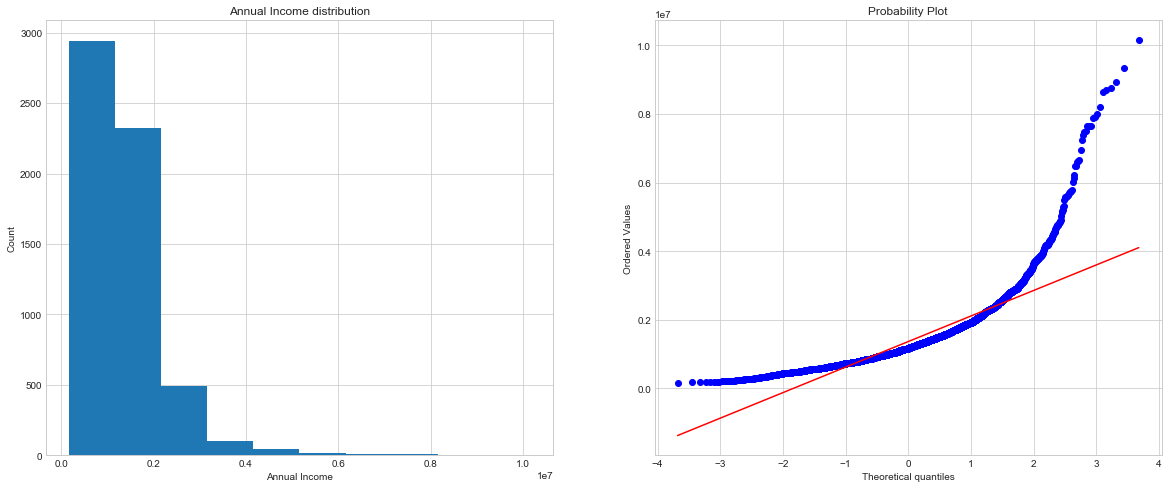

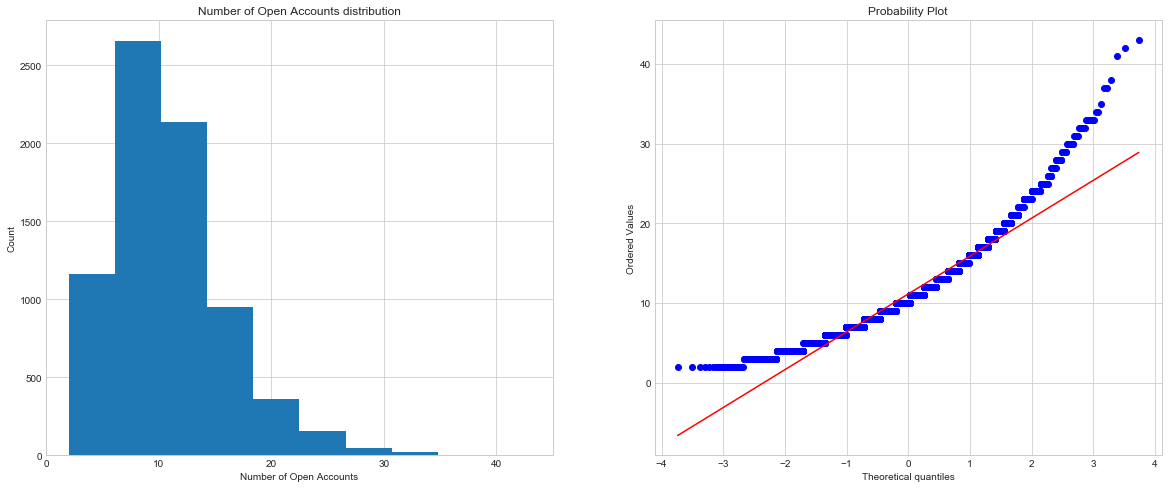

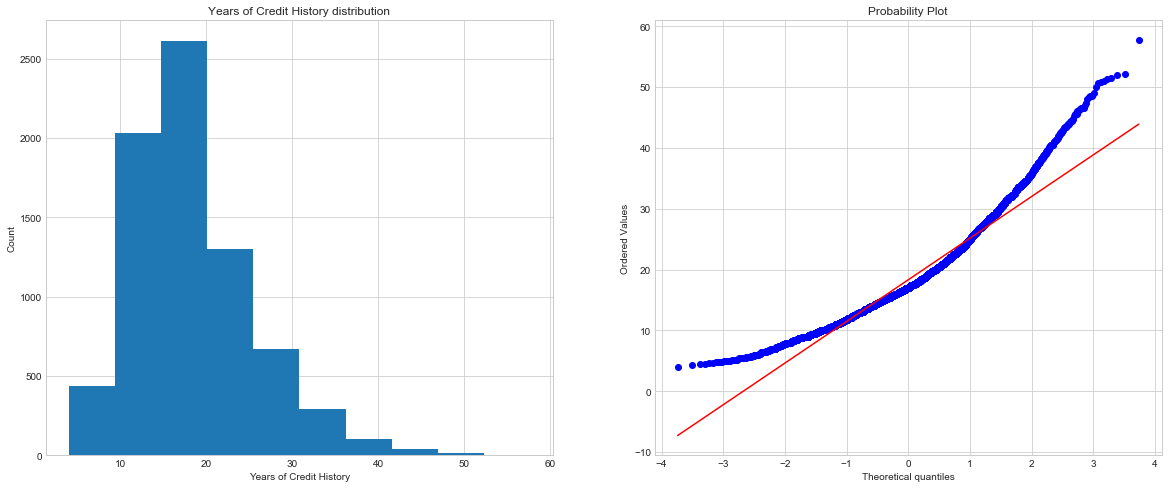

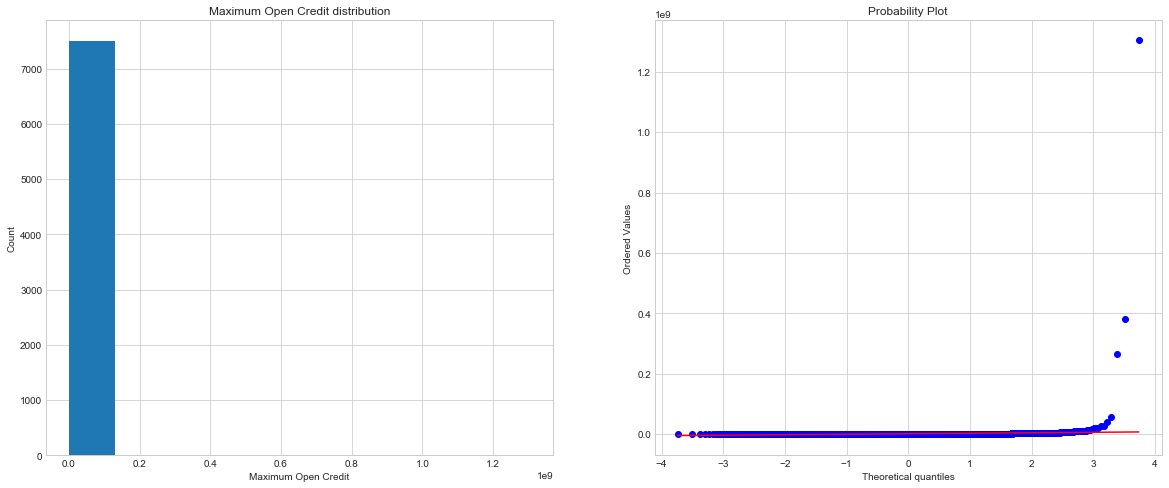

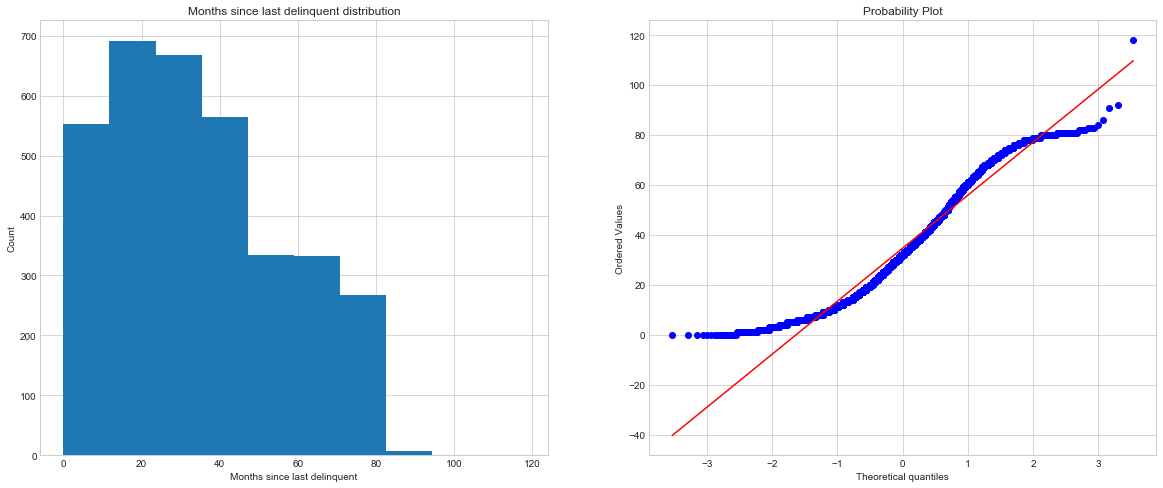

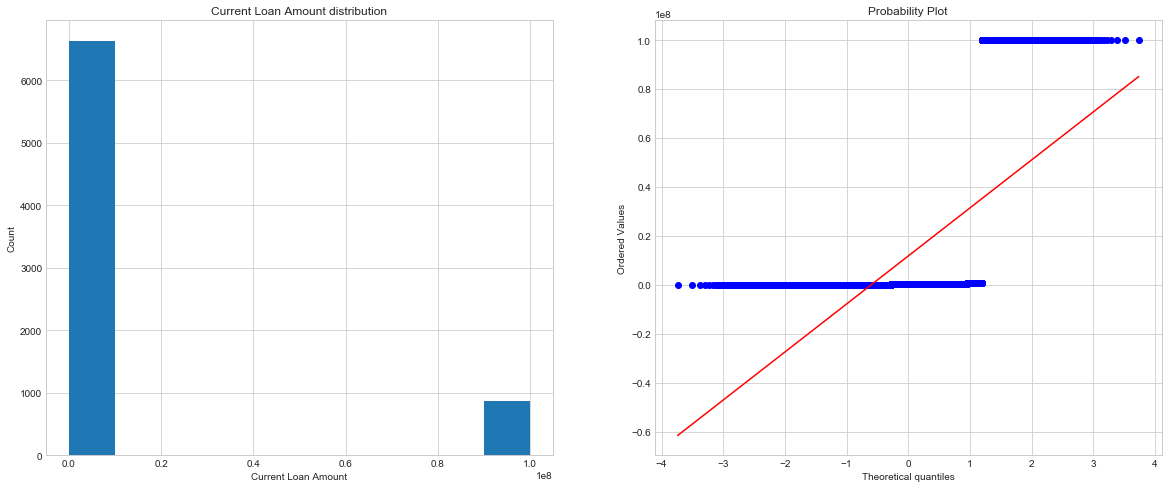

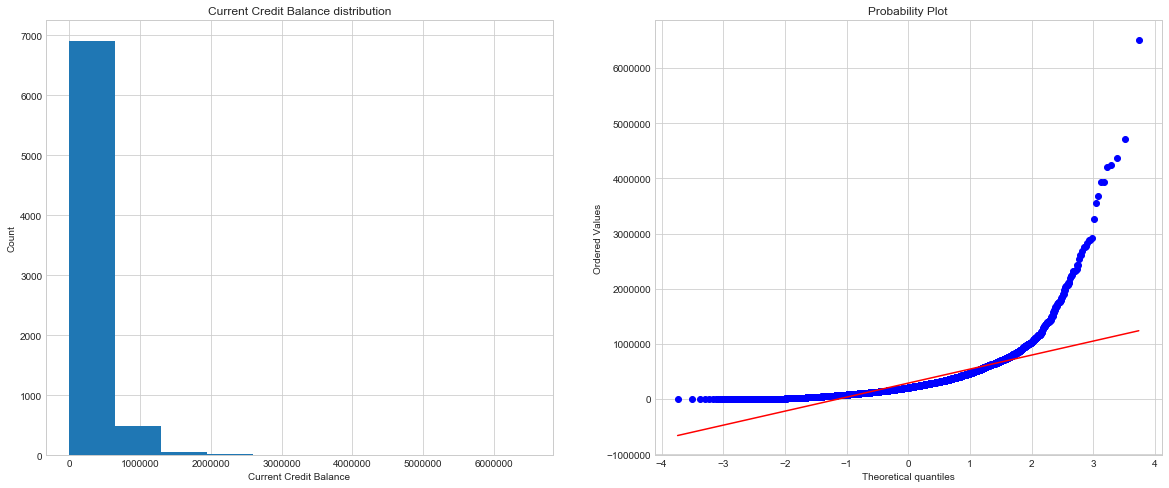

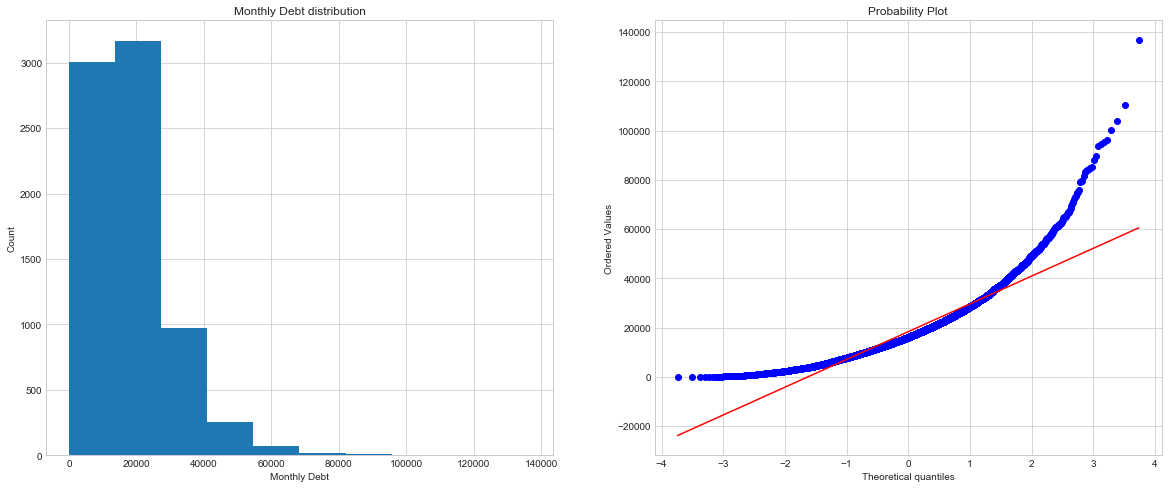

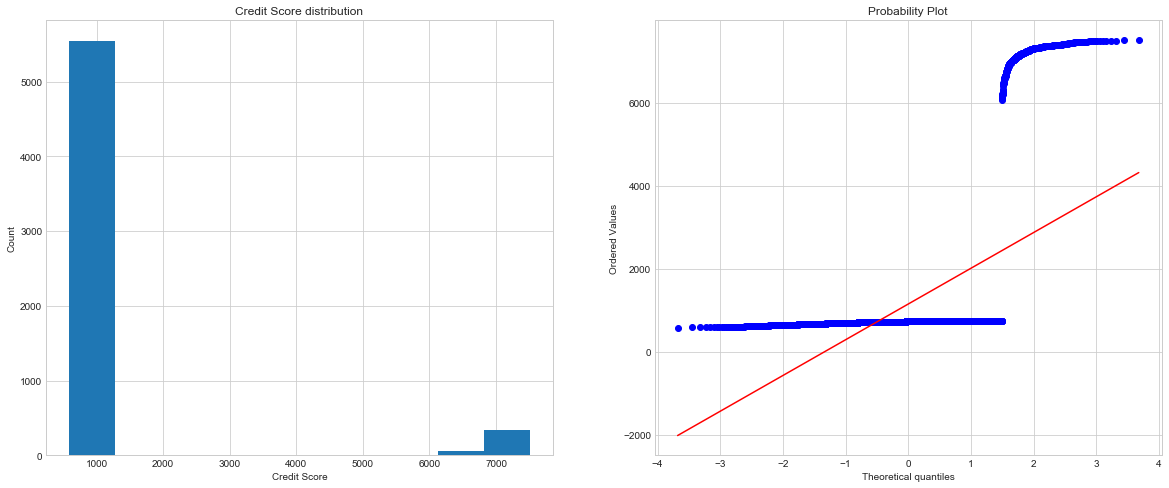

In [19]:
for v in feauters_with_numbers:
    s_v = df.loc[df[v].notna(), v]
    plt.figure(figsize=(20, 8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(v)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{v} distribution')
    s_v.hist()

    plt.subplot(122)
    probplot(s_v, dist='norm', plot=plt)


    plt.show()

### Проверим визуально равенства мат.ожиданий:

Ниже в целом подтверждаются выводы о различиях мат.ожиданий. Только для показателе *Current Credit Balance* равенство мат. ожиданий не выражено ярко, как в показателе *Months since last delinquent*

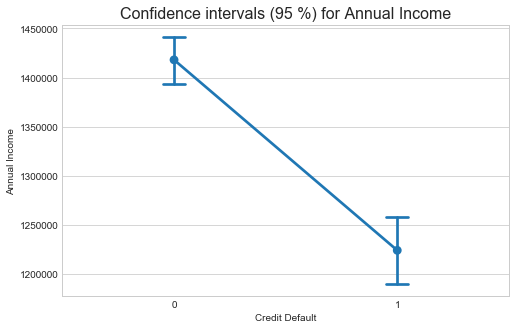

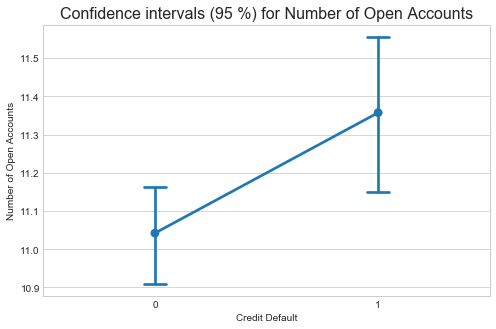

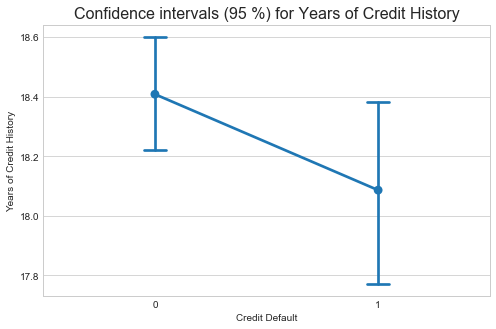

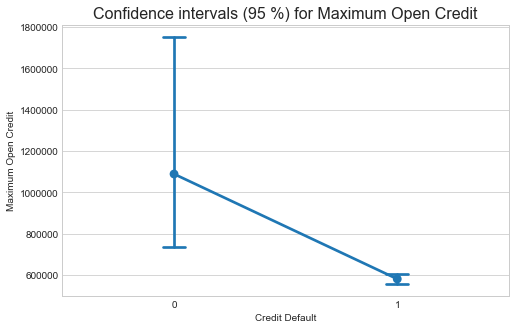

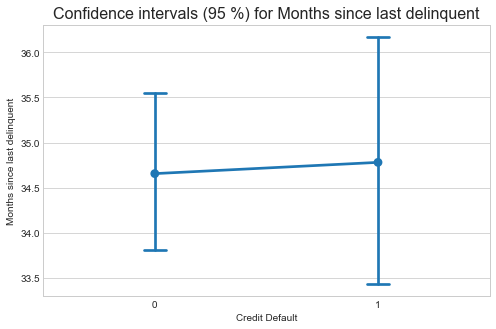

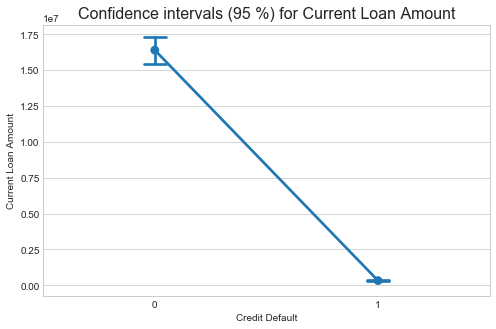

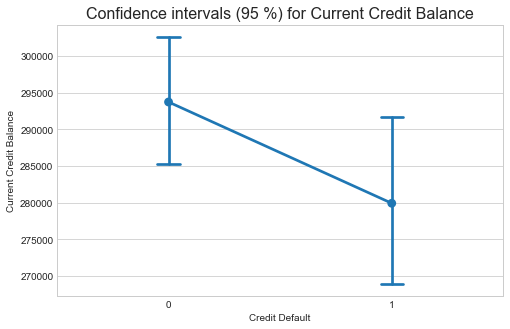

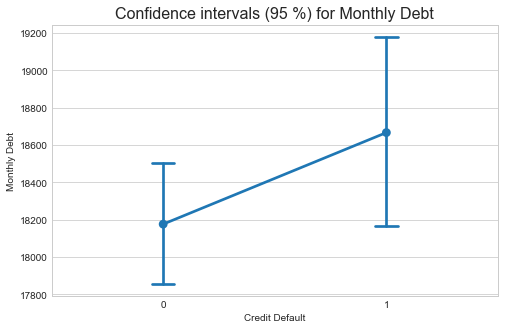

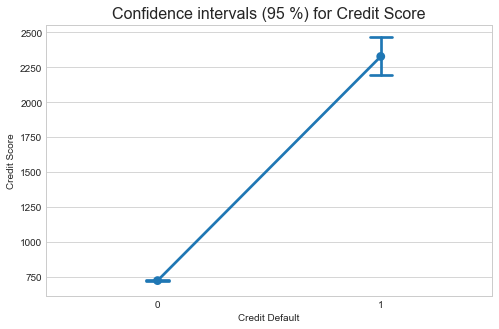

In [20]:
for v in feauters_with_numbers:
    df_v = df.loc[df[v].notna()]
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=target_feat, y=v, data=df_v, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {v}', fontdict={'fontsize': 16})
    plt.show()

### Оценим категориальные признаки в связке с целевым признаком

In [21]:
feauters_with_categories

['Home Ownership',
 'Years in current job',
 'Tax Liens',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term']

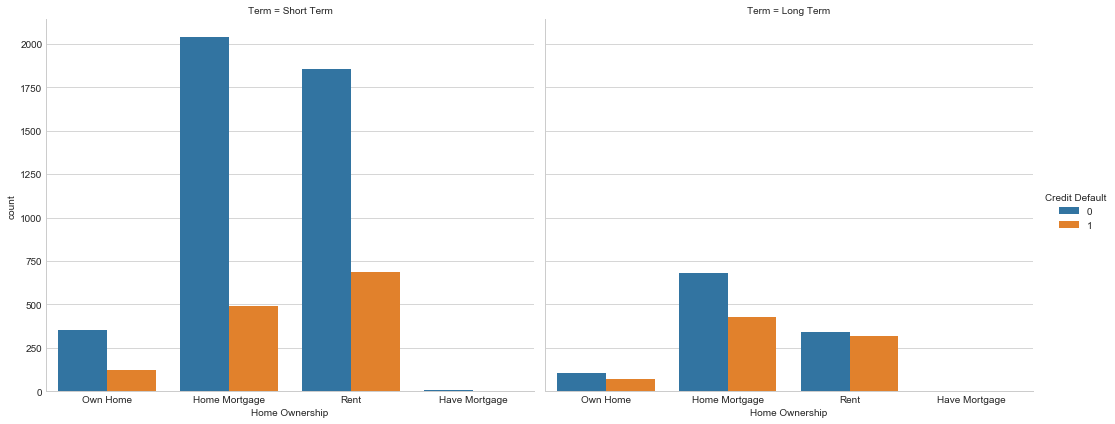

In [22]:
g = sns.catplot(x=feauters_with_categories[0], hue=target_feat, col=feauters_with_categories[-1], data=df, 
                kind='count', height=6, aspect=1.2)

__Вывод из графиков выше:__
1. В краткосрочных кредитах возврат выше
2. Хуже всех возвращают в категории Rent в обоих случаях

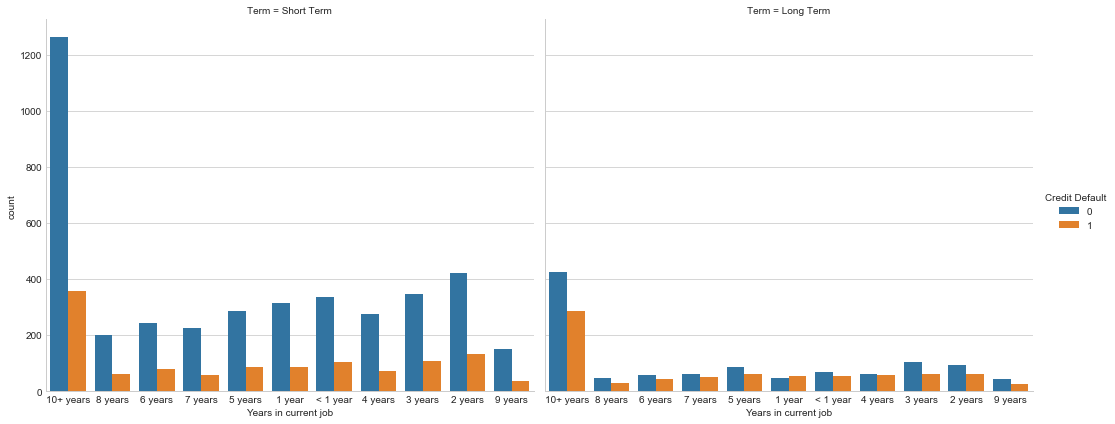

In [23]:
g = sns.catplot(x=feauters_with_categories[1], hue=target_feat, col=feauters_with_categories[-1], data=df, 
                kind='count', height=6, aspect=1.2)

__Вывод из графиков выше:__
1. В краткосрочных сложно на графике увидеть разницу в возвратах между годами. Надо смотреть на цифры
2. В долгосрочных кредитах в некоторых значениях Year кол-во невозвратов превышает или примерно равно кол-ву возвратов. В целом соотношения также надо смотреть в цифрах

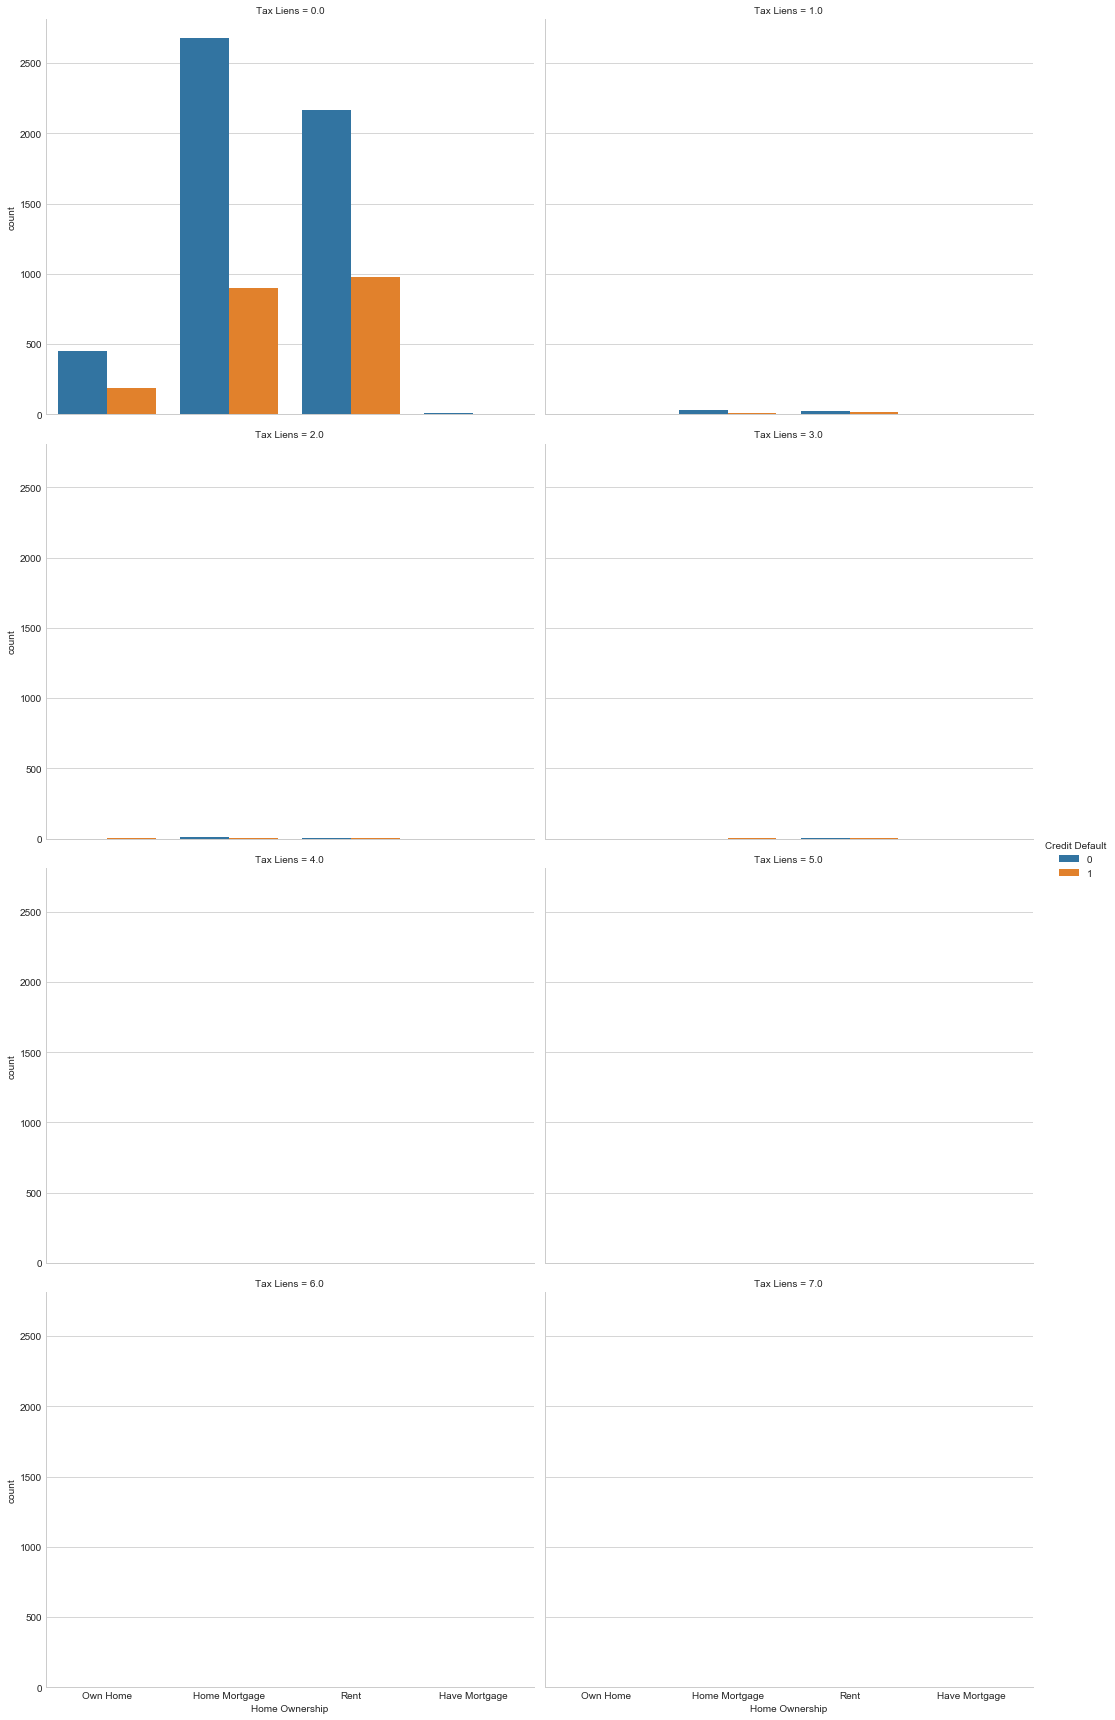

In [24]:
g = sns.catplot(x=feauters_with_categories[0], hue=target_feat, col=feauters_with_categories[2], data=df, 
                kind='count', height=6, aspect=1.2, col_wrap=2)

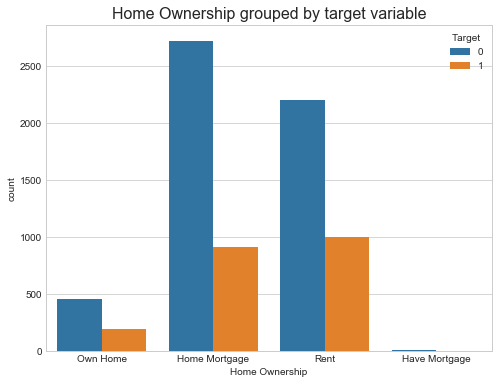

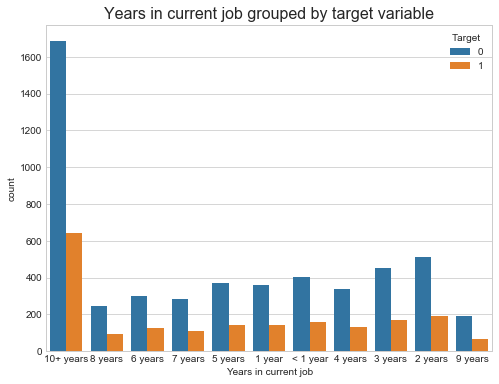

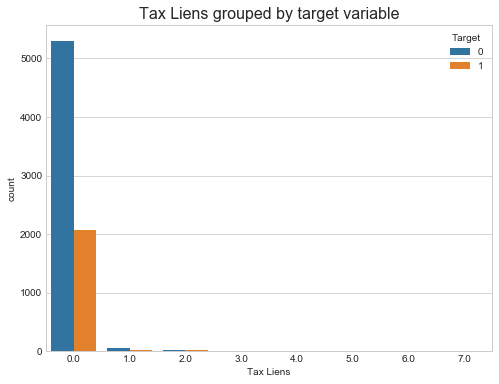

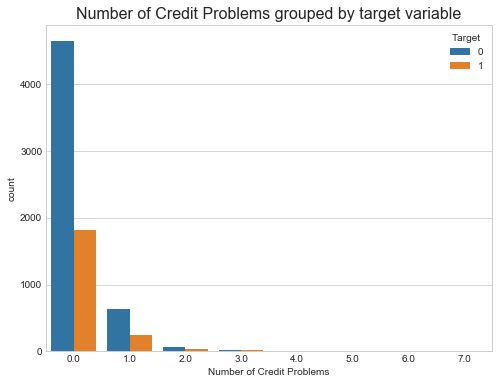

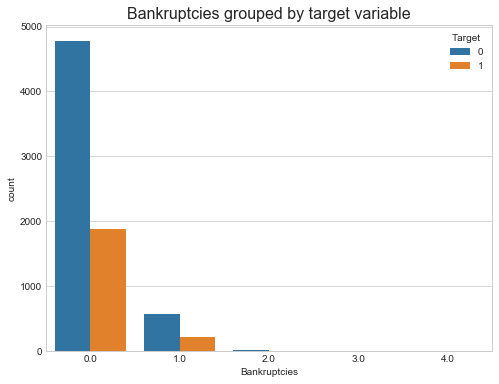

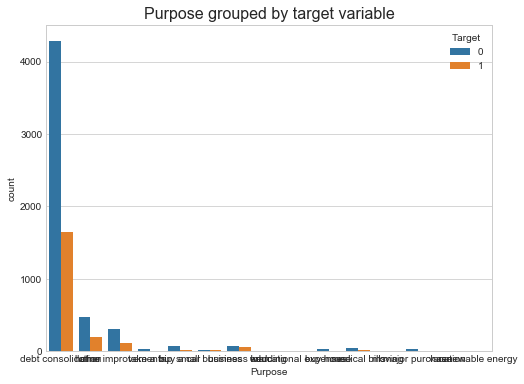

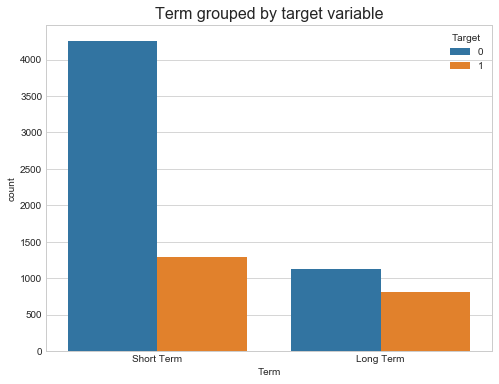

In [25]:
for v in feauters_with_categories:
    plt.figure(figsize=(8, 6))

    sns.countplot(x=v, hue=target_feat, data=df)
    plt.title(f'{v} grouped by target variable', fontdict={'fontsize': 16})
    plt.legend(title='Target', loc='upper right')

    plt.show()

__Вывод из графиков выше:__
Сложно увидеть разницу в возвратах между категориями. Надо смотреть на цифры

### Проверим частоты в группах:

In [45]:
def extend_describe_for_dummies_values(df, col_lst, target_name, col_for_count):
    """Функция считает и выводит:
    кол-во всего значений
    кол-во уникальных значений
    кол-во пропусков
    p-value для критерия Хи-Квадрат Пирсона
    """
    df_desc = pd.DataFrame(columns=col_lst)
    n = df.shape[0]
    
    for _ in range(5):
        df_desc = df_desc.append(pd.Series(), ignore_index=True)
    
    for v in col_lst:
        df_desc[v].iloc[[0]] = df[v].count()
        df_desc[v].iloc[[1]] = len(df[v].unique())
        
        null_amount = df.loc[df[v].isnull()].shape[0]
        df_desc[v].iloc[[2]] = null_amount
        df_desc[v].iloc[[3]] = round((1-null_amount/n) * 100, 2)
        
        #Критерий Хи-Квадрат для определения p-value
        table = df.pivot_table(values=col_for_count, index=v, columns=target_name, aggfunc='count')
        table.fillna(0, inplace=True)
        if table.shape[0] > 0:
            chi2, p, dof, expected = chi2_contingency(table, correction=False)
        else:
            p='-'
        df_desc[v].iloc[[4]] = p

    df_desc.rename(index={0:'count', 1:'uniques', 2:'null', 3:'fullness', 4:'p-value'}, inplace=True)

    return df_desc

In [27]:
#Признак с непустыми значениями, по которому будем считать кол-во значений в группах:
count_col = 'Number of Open Accounts'

In [28]:
extend_describe_for_dummies_values(df, feauters_with_categories, target_feat, count_col)

Home Ownership Years in current job  Tax Liens  \
count              7500                 7129       7500   
uniques               4                   12          8   
null                  0                  371          0   
fullness            100                95.05        100   
p-value     3.10599e-07             0.998453  0.0833009   

         Number of Credit Problems Bankruptcies     Purpose         Term  
count                         7500         7486        7500         7500  
uniques                          8            6          15            2  
null                             0           14           0            0  
fullness                       100        99.81         100          100  
p-value                  0.0195281     0.841366  0.00348611  1.15194e-55

Если p-value > 0.05, то можно допустить, что категории признака одинаково влияют на целевую переменную, а значит их можно объединить в один.

__Вывод:__
1. Надо заполнить пропущенные значения в "Years in current job" и "Bankruptcies"
2. Категории этих признаков скорей всего одинаково влияют на целевую переменную:


- Years in current job
- Tax Liens
- Bankruptcies

Далее проверим влияние категорий этих признаков отдельно:

In [29]:
def check_hi_square(df, check_col, target_name, col_for_count):
    table = df.pivot_table(values=col_for_count, index=check_col, columns=target_name, aggfunc='count')
    table.fillna(0, inplace=True)
    for n, v in enumerate(table.index):
        new_table = table.iloc[n:n+2, :]
        if new_table.shape[0] > 1:
            display(new_table)
            err = False
            try:
                chi2, p, dof, expected = chi2_contingency(new_table, correction=False)
            except ValueError as e:
                err = True
                print(e)
            if not err:
                print(p)

In [30]:
check_hi_square(df, 'Years in current job', target_feat, count_col)

Credit Default           0    1
Years in current job           
1 year                 362  142
10+ years             1688  644

0.7993668378145261


Credit Default           0    1
Years in current job           
10+ years             1688  644
2 years                512  193

0.9005881540466335


Credit Default          0    1
Years in current job          
2 years               512  193
3 years               450  170

0.9858763265554088


Credit Default          0    1
Years in current job          
3 years               450  170
4 years               338  131

0.8514816059910133


Credit Default          0    1
Years in current job          
4 years               338  131
5 years               371  145

0.9529628754696226


Credit Default          0    1
Years in current job          
5 years               371  145
6 years               302  124

0.7333780962281449


Credit Default          0    1
Years in current job          
6 years               302  124
7 years               285  111

0.7325888500890891


Credit Default          0    1
Years in current job          
7 years               285  111
8 years               247   92

0.7875316810171527


Credit Default          0   1
Years in current job         
8 years               247  92
9 years               194  65

0.5738728768855224


Credit Default          0    1
Years in current job          
9 years               194   65
< 1 year              404  159

0.34681405645177643


In [31]:
check_hi_square(df, 'Tax Liens', target_feat, count_col)

Credit Default       0       1
Tax Liens                     
0.0             5301.0  2065.0
1.0               59.0    24.0

0.8589061225016039


Credit Default     0     1
Tax Liens                 
1.0             59.0  24.0
2.0             15.0  15.0

0.0373556240628423


Credit Default     0     1
Tax Liens                 
2.0             15.0  15.0
3.0              5.0   5.0

1.0


Credit Default    0    1
Tax Liens               
3.0             5.0  5.0
4.0             3.0  3.0

1.0


Credit Default    0    1
Tax Liens               
4.0             3.0  3.0
5.0             1.0  1.0

1.0


Credit Default    0    1
Tax Liens               
5.0             1.0  1.0
6.0             2.0  0.0

0.24821307898992026


Credit Default    0    1
Tax Liens               
6.0             2.0  0.0
7.0             1.0  0.0

The internally computed table of expected frequencies has a zero element at (0, 1).


In [32]:
check_hi_square(df, 'Bankruptcies', target_feat, count_col)

Credit Default     0     1
Bankruptcies              
0.0             4782  1878
1.0              569   217

0.7278918214239571


Credit Default    0    1
Bankruptcies            
1.0             569  217
2.0              20   11

0.3376141378065672


Credit Default   0   1
Bankruptcies          
2.0             20  11
3.0              5   2

0.7277003776552851


Credit Default  0  1
Bankruptcies        
3.0             5  2
4.0             1  1

0.5707503880581739


__Вывод__:

- Попарный подсчет p-value показал, что все категории признаков можно объединить, кроме Tax Liens. Поскольку там одна из комбинаций категорий дала p-value < 0.05, что означает ее влияние на целевую переменную
- Т.о. можно не учитывать следующие признаки в модели:

Years in current job

Bankruptcies

### Сформируем итоговый датасет
- Очистим от слабо-заполненных признаков
- Заполним недостающие данные
- Создадим новые признаки
- Поменяем тип признаков

#### Обработаем некоторые показатели:

In [1101]:
def reformat_df(df_):
    """Комплексная функция для обработки тестового датасета"""
    df2_ = df_.copy()
    df2_['Job_years'] = df2_['Years in current job'].str.replace(r'[ \+a-z]+', '')
    df2_['Job_years'] = df2_['Job_years'].apply(lambda x: 0 if x=='<1' else x)
    df2_['Job_years'] = pd.to_numeric(df2_['Job_years'], errors='coerce')
    
    df2_['Score_level'] = df2_['Credit Score'].apply(lambda x: 1 if x>6000 else 0)
    df2_['Score_level'] = df2_['Score_level'].astype('int')
    
    df2_['Max_open_credit_level'] = df2_['Maximum Open Credit'].apply(lambda x: 1 if x>5000000 else 0)
    df2_['Max_open_credit_level'] = df2_['Max_open_credit_level'].astype('int')
    
    df2_['Bankruptcies'] = df2_['Bankruptcies'].fillna(0) #самое популярное значений
    df2_.drop(['Years in current job', 'Months since last delinquent'], axis=1, inplace=True)
    
    df2_['Term'] = df2_['Term'].replace({'Short Term': 1, 'Long Term': 0})
    
    return df2_

In [1090]:
def group_and_get_max_column(df_, group_cols, get_max_col, count_col):
    """
    Заполняет пропуски значений максимальным по кол-ву значений в группировке
    group_cols - список показателей для группировки
    get_max_col - показатель, который нужно дозаполнить
    count_col - показатель, по которому будем считать кол-во элементов
    """
    all_group_cols = group_cols + [get_max_col]
    group_1 = df_.groupby(all_group_cols, 
                    as_index=False).agg({count_col: "count"})
    group_2 = group_1.groupby(group_cols, 
                    as_index=False).agg({count_col: "max"})
    
    final_cols = group_cols + [count_col]
    
    final_group = pd.merge(group_2, group_1, on=final_cols, how='left').rename(columns={get_max_col: 'max_value'})
    final_group.drop(count_col, axis=1, inplace=True)
    final_group.drop_duplicates(group_cols, keep='first', inplace=True)
    
    df2_ = pd.merge(df_, final_group, on=group_cols, how='left')
    df2_.loc[df2_[get_max_col].isnull(), get_max_col] = df2_.loc[df2_[get_max_col].isnull(), 'max_value']
    df2_.drop('max_value', axis=1, inplace=True)
    
    
    return df2_

In [1091]:
def group_and_get_mean_column(df_, group_cols, get_mean_col):
    """
    Заполняет пропуски значений средним по признаку get_mean_col в группировке group_cols
    """
    mean_group = df_.groupby(group_cols, 
    as_index=False).agg({
        get_mean_col: "mean"
        }).sort_values(
            by=[get_mean_col], 
            ascending=False).rename(columns={get_mean_col:'mean_value'})
    
    df2_ = pd.merge(df_, mean_group, on=group_cols, how='left')
    df2_[get_mean_col] = df2_[get_mean_col].fillna(value=df2_['mean_value'])
    df2_.drop('mean_value', axis=1, inplace=True)
    
    return df2_

In [1092]:
def fill_na_years_job(df_):
    """Заполняем пропущенные значения Job_years по кол-ву значений в других признаках"""
    min_v = df_['Years of Credit History'].min()
    df_['Years_history_group'] = df_['Years of Credit History'].apply(lambda x: np.ceil((x - min_v + 0.00001)/0.5))
    df2_ = group_and_get_max_column(df_,
                               group_cols=['Home Ownership', 'Years_history_group'], 
                               get_max_col='Job_years', 
                               count_col='Years of Credit History')

    df3_ = group_and_get_max_column(df2_, 
                               group_cols=['Years_history_group'], 
                               get_max_col='Job_years', 
                               count_col='Years of Credit History')
    
    df4_ = group_and_get_max_column(df3_, 
                               group_cols=['Home Ownership'], 
                               get_max_col='Job_years', 
                               count_col='Years of Credit History')
    
    df4_.drop('Years_history_group', axis=1, inplace=True)
    
    if df4_['Job_years'].isna().sum() > 0:
        print(df4_['Job_years'].isna().sum())
        return df4_
    else:
        return df4_

In [1093]:
def fill_na_annual_income_score(df_, get_mean_col):
    """Заполняем пропуски признака Annual Income"""
    group_cols = ['Purpose', 'Max_open_credit_level', 'Tax Liens', 'Bankruptcies', 'Home Ownership']
    
    df3_1 = group_and_get_mean_column(df_, group_cols=group_cols, get_mean_col=get_mean_col)
    
    group_cols = ['Purpose', 'Max_open_credit_level', 'Tax Liens', 'Bankruptcies']
    df3_2 = group_and_get_mean_column(df3_1, group_cols=group_cols, get_mean_col=get_mean_col)
    
    group_cols = ['Purpose', 'Max_open_credit_level', 'Tax Liens']
    df3_3 = group_and_get_mean_column(df3_2, group_cols=group_cols, get_mean_col=get_mean_col)
    
    group_cols = ['Tax Liens', 'Max_open_credit_level']
    df3_4 = group_and_get_mean_column(df3_3, group_cols=group_cols, get_mean_col=get_mean_col)
    
    if df3_4[get_mean_col].isna().sum() > 0:
        group_cols = ['Tax Liens']
        df3_5 = group_and_get_mean_column(df3_4, group_cols=group_cols, get_mean_col=get_mean_col)
        return df3_5
    else:
        return df3_4

In [1094]:
def fill_mean_value_by_group(df_, group_cols, get_mean_col, col_name):
    """Функция создает признак col_name со средним значением по признаку get_mean_col с группировкой по group_cols"""
    mean_group = df5.groupby(group_cols, as_index=False).agg({
        get_mean_col: "mean"}).sort_values(
        by=[get_mean_col], 
        ascending=False).rename(columns={get_mean_col:col_name})
    df2_ = pd.merge(df_, mean_group, on=group_cols, how='left')
    
    return df2_

In [1095]:
def fill_count_value_by_group(df_, group_cols, get_count_col, col_name):
    """Функция создает признак col_name с кол-вом наблюдений по признаку get_count_col с группировкой по group_cols"""
    mean_group = df_.groupby(group_cols, as_index=False).agg({
        get_count_col: "count"}).sort_values(
        by=[get_count_col], 
        ascending=False).rename(columns={get_count_col:col_name})
    df2_ = pd.merge(df_, mean_group, on=group_cols, how='left')
    
    return df2_

In [1102]:
df_test2 = reformat_df(df_test)

In [1106]:
df_test3 = fill_na_years_job(df_test2)

In [1107]:
df_test4 = fill_na_annual_income_score(df_test3, 'Annual Income')

In [1108]:
df_test5 = fill_na_annual_income_score(df_test4, 'Credit Score')

In [1109]:
df_test5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 17 columns):
Home Ownership               2500 non-null object
Annual Income                2500 non-null float64
Tax Liens                    2500 non-null float64
Number of Open Accounts      2500 non-null float64
Years of Credit History      2500 non-null float64
Maximum Open Credit          2500 non-null float64
Number of Credit Problems    2500 non-null float64
Bankruptcies                 2500 non-null float64
Purpose                      2500 non-null object
Term                         2500 non-null int64
Current Loan Amount          2500 non-null float64
Current Credit Balance       2500 non-null float64
Monthly Debt                 2500 non-null float64
Credit Score                 2500 non-null float64
Job_years                    2500 non-null float64
Score_level                  2500 non-null int32
Max_open_credit_level        2500 non-null int32
dtypes: float64(12), int32(2), int

In [1110]:
df2 = reformat_df(df)

In [1111]:
df3 = fill_na_years_job(df2)

In [1112]:
df4 = fill_na_annual_income_score(df3, 'Annual Income')

In [1113]:
df5 = fill_na_annual_income_score(df4, 'Credit Score')

In [1114]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Home Ownership               7500 non-null object
Annual Income                7500 non-null float64
Tax Liens                    7500 non-null float64
Number of Open Accounts      7500 non-null float64
Years of Credit History      7500 non-null float64
Maximum Open Credit          7500 non-null float64
Number of Credit Problems    7500 non-null float64
Bankruptcies                 7500 non-null float64
Purpose                      7500 non-null object
Term                         7500 non-null int64
Current Loan Amount          7500 non-null float64
Current Credit Balance       7500 non-null float64
Monthly Debt                 7500 non-null float64
Credit Score                 7500 non-null float64
Credit Default               7500 non-null int64
Job_years                    7500 non-null float64
Score_level                  7500 non-null int32
Max_open_credit_level        7500 

## Создаем показатели:
- кол-во банкротов по Home Ownership
- кол-во банкротов по Job_years
- кол-во банкротов по Number of Open Accounts
- кол-во банкротов по Number of Credit Problems
- кол-во банкротов по Purpose

Аналогично
- кол-во Number of Credit Problems

И
- сред. Current Loan Amount по кол-во банкротов
- сред. Current Loan Amount по Job_years
- сред. Current Loan Amount по Home Ownership
- сред. Current Loan Amount по Number of Open Accounts
- сред. Current Loan Amount по Tax Liens
- сред. Current Loan Amount по Purpose

Аналогично:
- сред. Annual Income
- сред. Current Credit
- сред. Monthly Debt
- сред. Maximum Open Credit
- сред. Credit Score

In [697]:
#Средние по категориям ничего не дают

# cat_lst = ['Bankruptcies', 'Home Ownership', 'Job_years', 'Number of Open Accounts', 'Tax Liens', 'Purpose', 
#            'Number of Credit Problems']

# num_lst = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Years of Credit History', 'Maximum Open Credit', 
#            'Current Credit Balance', 'Monthly Debt']
# df_begin = df5
# for cat in cat_lst:
#     for num in num_lst:
#         new_col_name = (cat+'_'+num+'_mean').replace(' ', '_')
#         df6 = fill_mean_value_by_group(df_begin, all_group_cols, count_col, new_col_name)
#         df_begin = df6

Bankruptcies_Current_Loan_Amount_mean
Bankruptcies_Credit_Score_mean
Bankruptcies_Annual_Income_mean
Bankruptcies_Years_of_Credit_History_mean
Bankruptcies_Maximum_Open_Credit_mean
Bankruptcies_Current_Credit_Balance_mean
Bankruptcies_Monthly_Debt_mean
Home_Ownership_Current_Loan_Amount_mean
Home_Ownership_Credit_Score_mean
Home_Ownership_Annual_Income_mean
Home_Ownership_Years_of_Credit_History_mean
Home_Ownership_Maximum_Open_Credit_mean
Home_Ownership_Current_Credit_Balance_mean
Home_Ownership_Monthly_Debt_mean
Job_years_Current_Loan_Amount_mean
Job_years_Credit_Score_mean
Job_years_Annual_Income_mean
Job_years_Years_of_Credit_History_mean
Job_years_Maximum_Open_Credit_mean
Job_years_Current_Credit_Balance_mean
Job_years_Monthly_Debt_mean
Number_of_Open_Accounts_Current_Loan_Amount_mean
Number_of_Open_Accounts_Credit_Score_mean
Number_of_Open_Accounts_Annual_Income_mean
Number_of_Open_Accounts_Years_of_Credit_History_mean
Number_of_Open_Accounts_Maximum_Open_Credit_mean
Number_of_Op

In [794]:
# Эти тоже ничего не дают:
# df6['Annual_Income_func'] = df6['Annual Income']/df6['Number of Open Accounts']
# df6['Annual_Income_func2'] = np.log(df6['Annual Income']/df6['Number of Open Accounts'])

In [974]:
# Эти тоже ничего не дают:
# df5['Term_Year'] = df5['Term'].apply(lambda x: str(x)) + ' ' + df5['Job_years'].apply(lambda x: str(x))
# df5['Term_Home'] = df5['Term'].apply(lambda x: str(x)) + ' ' + df5['Home Ownership']

In [942]:
# Эти тоже ничего не дают:
#Корни квадратные
# df5['Income_sqrt'] = np.sqrt(df5['Annual Income'])
# df5['Loan_sqrt'] = np.sqrt(df5['Current Loan Amount'])
# df5['Debt_sqrt'] = np.sqrt(df5['Monthly Debt'])
# df5['Credit_sqrt'] = np.sqrt(df5['Credit Score'])
# df5['Maximum_sqrt'] = np.sqrt(df5['Maximum Open Credit'])

In [975]:
# Эти тоже ничего не дают:
# all_group_cols = [
#     ['Bankruptcies', 'Home Ownership'],
#     ['Bankruptcies', 'Job_years'],
#     ['Bankruptcies', 'Number of Open Accounts'],
#     ['Bankruptcies', 'Number of Credit Problems'],
#     ['Bankruptcies', 'Purpose'],
#     ['Bankruptcies', 'Term_Year'],
#     ['Bankruptcies', 'Term_Home'],
# ]
# count_col = 'Credit Default'
# df_begin = df5
# for mygroup in all_group_cols:
#     new_col_name = (mygroup[1]+'_b_count').replace(' ', '_')
#     df6 = fill_count_value_by_group(df_begin, mygroup, count_col, new_col_name)
#     df_begin = df6

In [976]:
# Эти тоже ничего не дают:
# all_group_cols = [
#     ['Number of Credit Problems', 'Home Ownership'],
#     ['Number of Credit Problems', 'Job_years'],
#     ['Number of Credit Problems', 'Number of Open Accounts'],
#     ['Number of Credit Problems', 'Purpose'],
#     ['Number of Credit Problems', 'Term_Year'],
#     ['Number of Credit Problems', 'Term_Home'],
# ]
# count_col = 'Credit Default'
# df_begin = df6
# for mygroup in all_group_cols:
#     new_col_name = (mygroup[1]+'_p_count').replace(' ', '_')
#     df7 = fill_count_value_by_group(df_begin, mygroup, count_col, new_col_name)
#     df_begin = df7

In [977]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 33 columns):
Home Ownership                       7500 non-null object
Annual Income                        7500 non-null float64
Tax Liens                            7500 non-null float64
Number of Open Accounts              7500 non-null float64
Years of Credit History              7500 non-null float64
Maximum Open Credit                  7500 non-null float64
Number of Credit Problems            7500 non-null float64
Bankruptcies                         7500 non-null float64
Purpose                              7500 non-null object
Term                                 7500 non-null int64
Current Loan Amount                  7500 non-null float64
Current Credit Balance               7500 non-null float64
Monthly Debt                         7500 non-null float64
Credit Score                         7500 non-null float64
Credit Default                       7500 non-null int64
Job_years     

In [1115]:
df_final = df5
df_test_final = df_test5

### Последние приготовления

In [1116]:
#Балансировка классов - 36%/64% - в норме
df_final[target_feat].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [1117]:
df_final.to_csv("df_final.csv", sep=",", index=False)
df_test_final.to_csv("df_test_final.csv", sep=",", index=False)

In [1051]:
y = df_final[target_feat]
X = df_final.drop(target_feat, axis=1)

In [1052]:
X = pd.get_dummies(X)
feature_names = X.columns

In [522]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1034]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 33):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, 1.3, 1, 2])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [524]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [876]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [911]:
def plotImp(columns, model, num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    sns.set(font_scale = 1)

## Протестируем логистическую регрессию:

In [863]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [864]:
scaler = StandardScaler()

In [865]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_names)

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [866]:
lr = LogisticRegression(solver="liblinear")

lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      4074
           1       0.82      0.26      0.40      1551

    accuracy                           0.78      5625
   macro avg       0.80      0.62      0.63      5625
weighted avg       0.79      0.78      0.74      5625

TEST

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1313
           1       0.85      0.25      0.39       562

    accuracy                           0.76      1875
   macro avg       0.80      0.62      0.62      1875
weighted avg       0.78      0.76      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1288   25
1                420  142


## Протестируем KNN

In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [709]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_names)

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [710]:
for n in range(5, 10):
    print('\nNeighbors =', n)
    model_knn = KNeighborsClassifier(n_neighbors=n)
    model_knn.fit(X_train, y_train)

    y_train_pred = model_knn.predict(X_train)
    y_test_pred = model_knn.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


Neighbors = 5
TRAIN

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4074
           1       0.79      0.48      0.60      1551

    accuracy                           0.82      5625
   macro avg       0.81      0.72      0.74      5625
weighted avg       0.82      0.82      0.81      5625

TEST

              precision    recall  f1-score   support

           0       0.71      0.94      0.81      1313
           1       0.42      0.10      0.17       562

    accuracy                           0.69      1875
   macro avg       0.57      0.52      0.49      1875
weighted avg       0.62      0.69      0.62      1875

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1233  80
1                503  59

Neighbors = 6
TRAIN

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4074
           1       0.87      0.35      0.49      1551

    accuracy  

## Протестируем Случайный лес

In [957]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [869]:
parameters = {
    'n_estimators': [200, 300],
    'max_features': np.arange(14, 18),
    'max_depth': np.arange(14, 18),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(criterion='entropy'),
    param_grid=parameters,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

In [871]:
%%time
# clf.fit(X_train, y_train)

Wall time: 2min 4s


GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=-1,
             param_grid={'max_depth': array([14, 15, 16, 17]),
                         'max_features': array([14, 15, 16, 17]),
                         'n_estimators': [200, 300]},
             scoring='f1_macro')

In [872]:
# clf.best_params_

{'max_depth': 17, 'max_features': 14, 'n_estimators': 200}

Fold #1
TRAIN

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      4298
           1       1.00      0.60      0.75      1702

    accuracy                           0.89      6000
   macro avg       0.93      0.80      0.84      6000
weighted avg       0.90      0.89      0.88      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1089
           1       0.78      0.25      0.38       411

    accuracy                           0.78      1500
   macro avg       0.78      0.61      0.62      1500
weighted avg       0.78      0.78      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1060   29
1                308  103


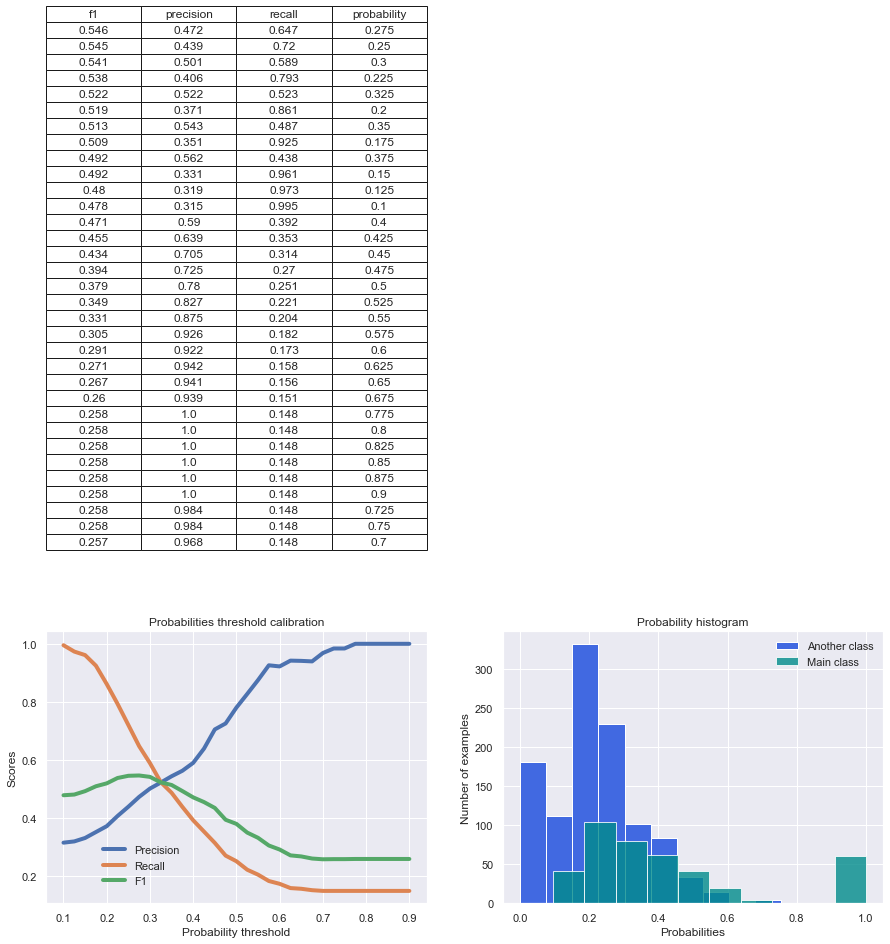

Fold #2
TRAIN

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4326
           1       1.00      0.60      0.75      1674

    accuracy                           0.89      6000
   macro avg       0.93      0.80      0.84      6000
weighted avg       0.90      0.89      0.88      6000

TEST

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1061
           1       0.79      0.26      0.39       439

    accuracy                           0.76      1500
   macro avg       0.77      0.62      0.62      1500
weighted avg       0.77      0.76      0.72      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1030   31
1                324  115


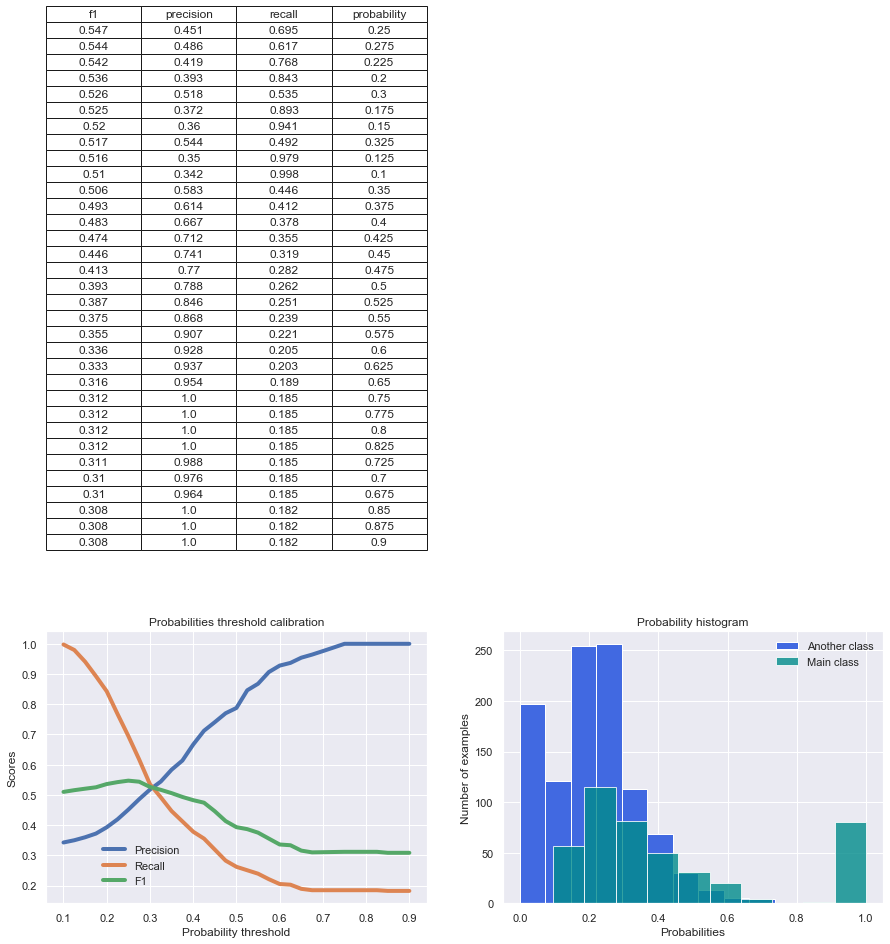

Fold #3
TRAIN

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      4287
           1       1.00      0.58      0.74      1713

    accuracy                           0.88      6000
   macro avg       0.93      0.79      0.83      6000
weighted avg       0.90      0.88      0.87      6000

TEST

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1100
           1       0.78      0.30      0.44       400

    accuracy                           0.79      1500
   macro avg       0.79      0.64      0.66      1500
weighted avg       0.79      0.79      0.76      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1066   34
1                278  122


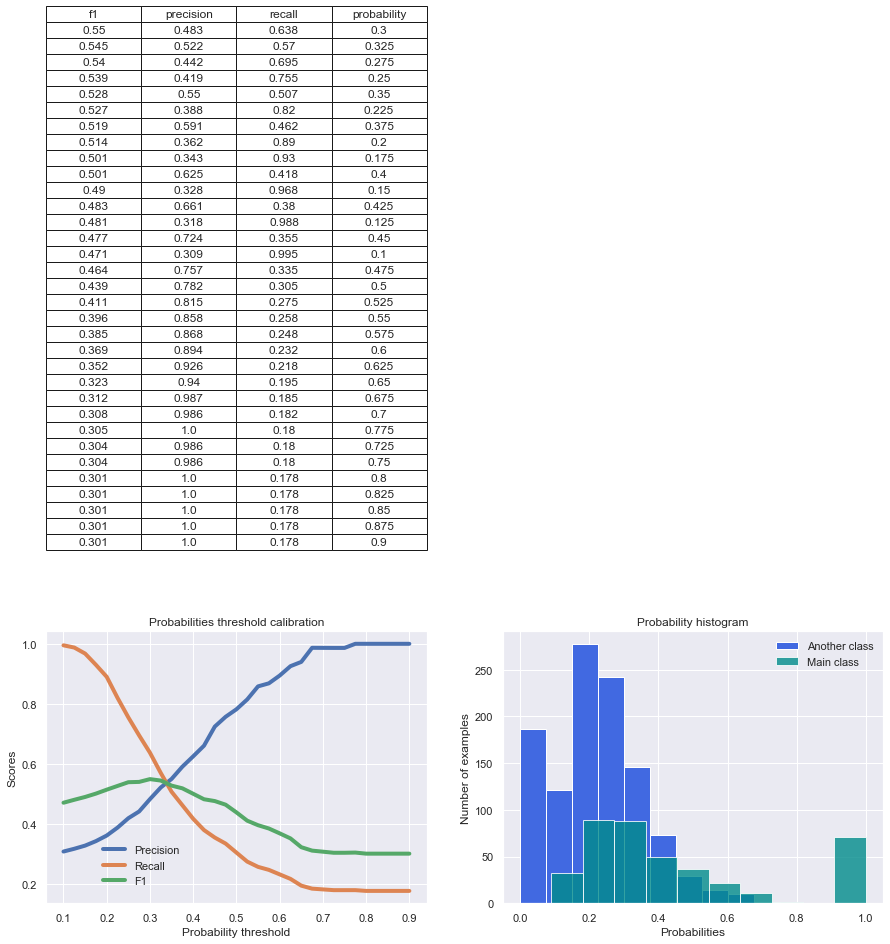

Fold #4
TRAIN

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      4297
           1       1.00      0.60      0.75      1703

    accuracy                           0.89      6000
   macro avg       0.93      0.80      0.84      6000
weighted avg       0.90      0.89      0.88      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1090
           1       0.81      0.34      0.48       410

    accuracy                           0.80      1500
   macro avg       0.80      0.65      0.68      1500
weighted avg       0.80      0.80      0.77      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1058   32
1                271  139


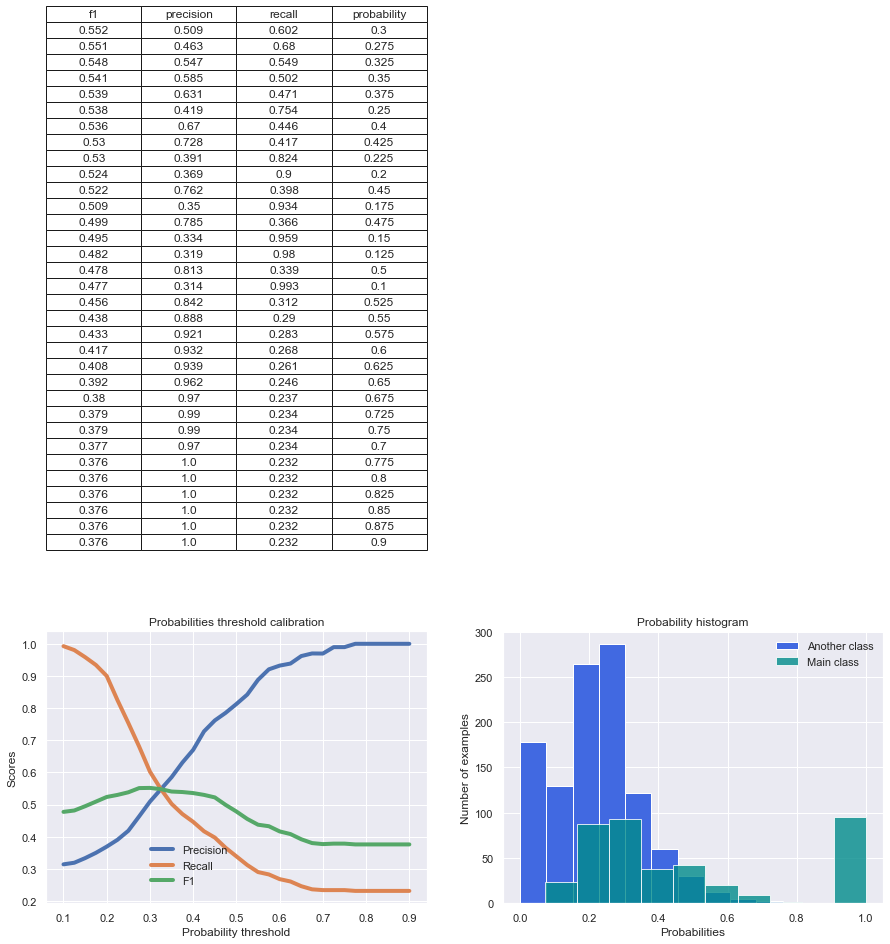

Fold #5
TRAIN

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4340
           1       1.00      0.61      0.76      1660

    accuracy                           0.89      6000
   macro avg       0.93      0.80      0.84      6000
weighted avg       0.91      0.89      0.88      6000

TEST

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1047
           1       0.81      0.30      0.43       453

    accuracy                           0.77      1500
   macro avg       0.79      0.63      0.64      1500
weighted avg       0.78      0.77      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1016   31
1                319  134


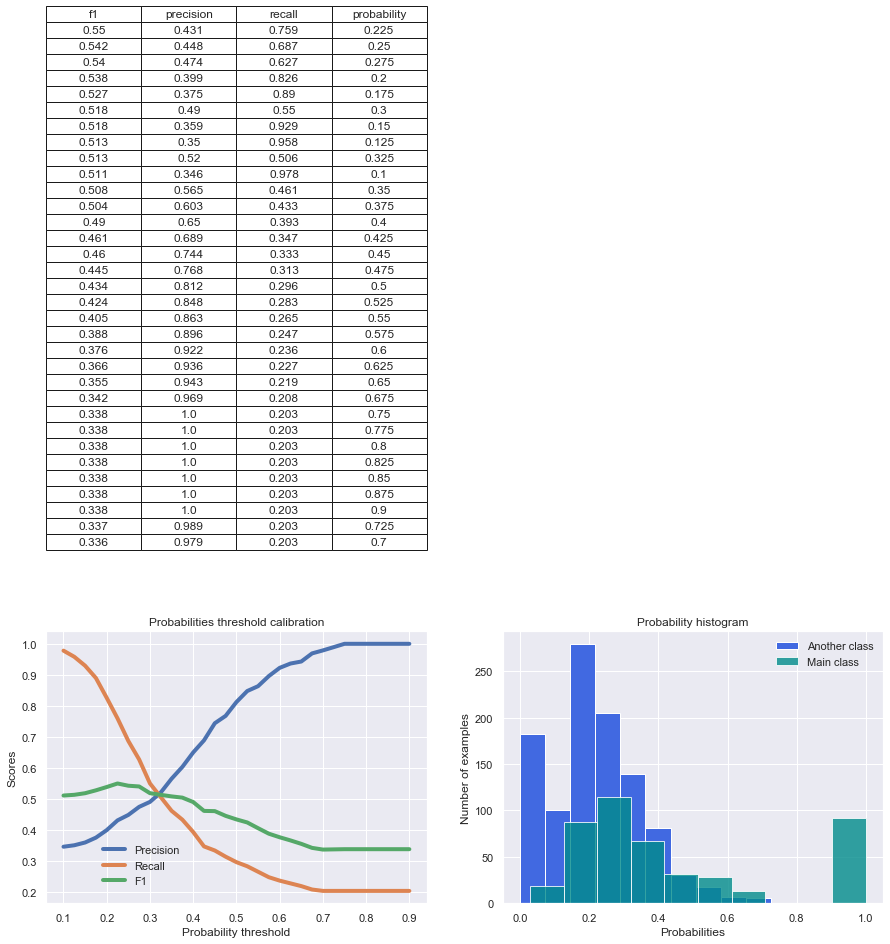

In [1054]:
kf = KFold(n_splits=5)

res_lst = []
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f'Fold #{fold}')
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
    
    clf = RandomForestClassifier(max_depth=14, 
                             max_features=14,
                             n_estimators=600, 
                             criterion='entropy'
                            )

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_pred_probs = clf.predict_proba(X_test)

    res_lst.append((clf, y_test_pred_probs, y_test))
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [783]:
#Добавил признак "Current Loan Amount х2"
#при probability 0.3:
f1 = [0.537, 0.528, 0.54, 0.546, 0.52]
pr = [0.502, 0.521, 0.475, 0.499, 0.499]
re = [0.577, 0.535, 0.625, 0.602, 0.553]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5342
precision 0.4992000000000001
recall 0.5784


In [728]:
#при probability 0.3:
f1 = [0.539, 0.528, 0.543, 0.547, 0.517]
pr = [0.51, 0.522, 0.488, 0.506, 0.506]
re = [0.572, 0.533, 0.612, 0.595, 0.528]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5348
precision 0.5064
recall 0.5680000000000001


In [1055]:
final_columns = X_train.columns
final_model = clf

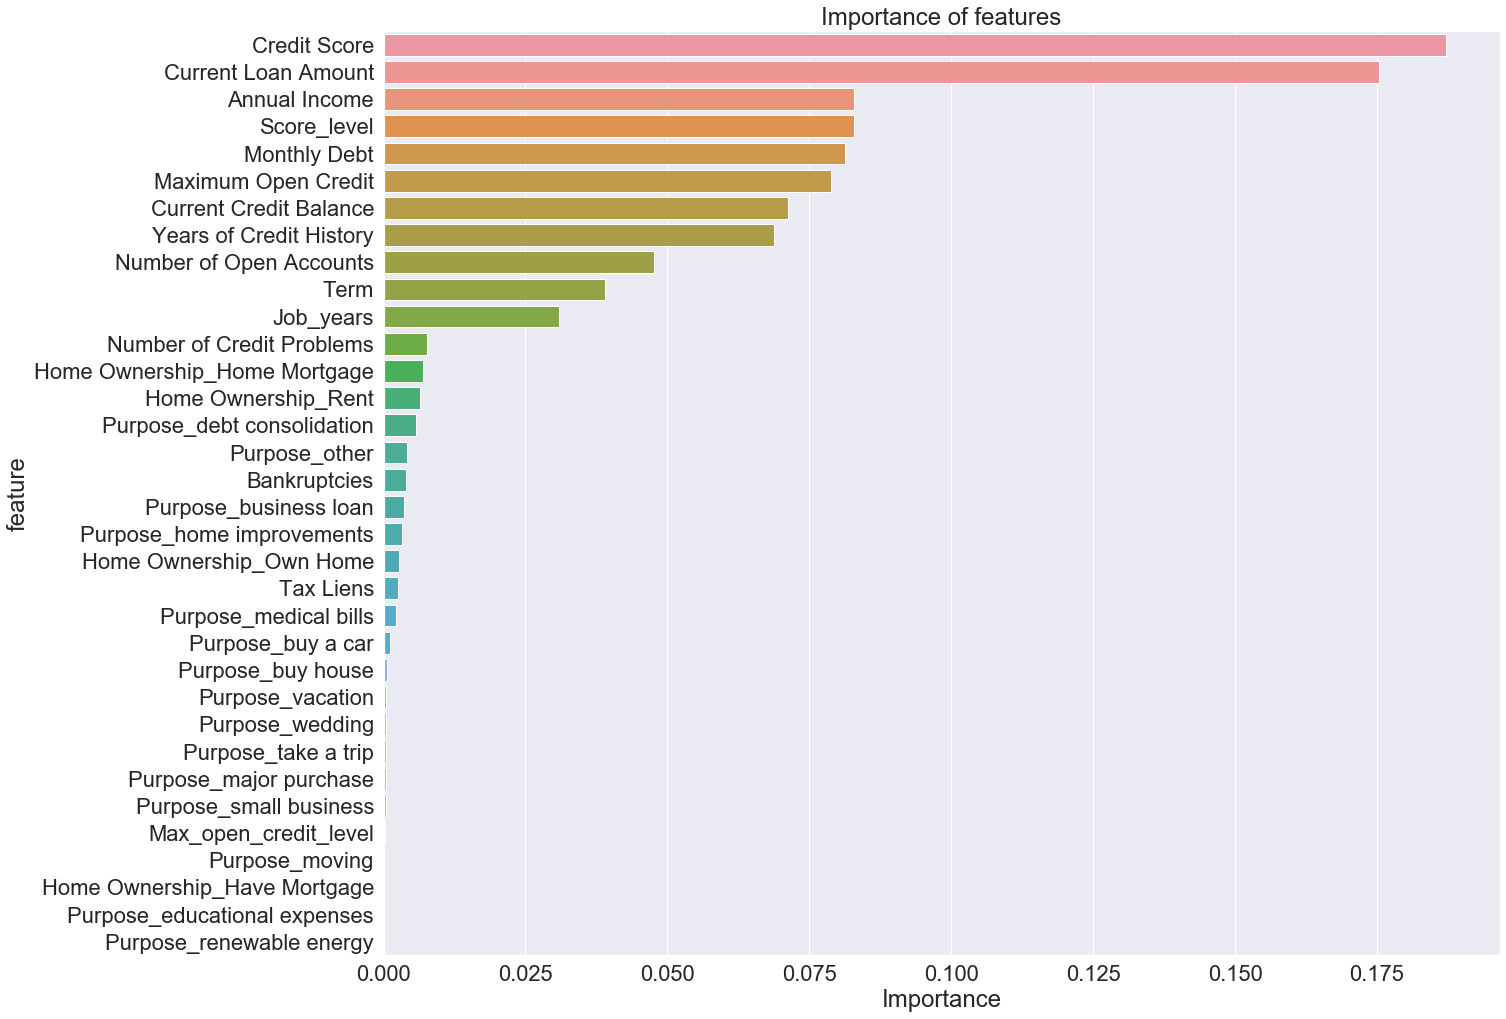

In [1056]:
sns.set(font_scale = 2)
important_features_top = show_feature_importances(final_columns, final_model.feature_importances_, get_top=20)
sns.set(font_scale = 1)

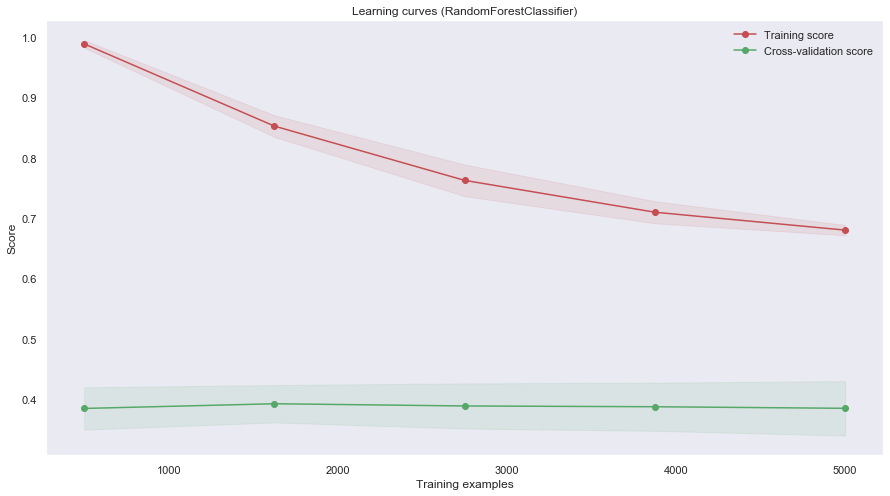

In [716]:
show_learning_curve_plot(final_model, X, y)

In [717]:
y_test_pred_probs = final_model.predict_proba(X_test)

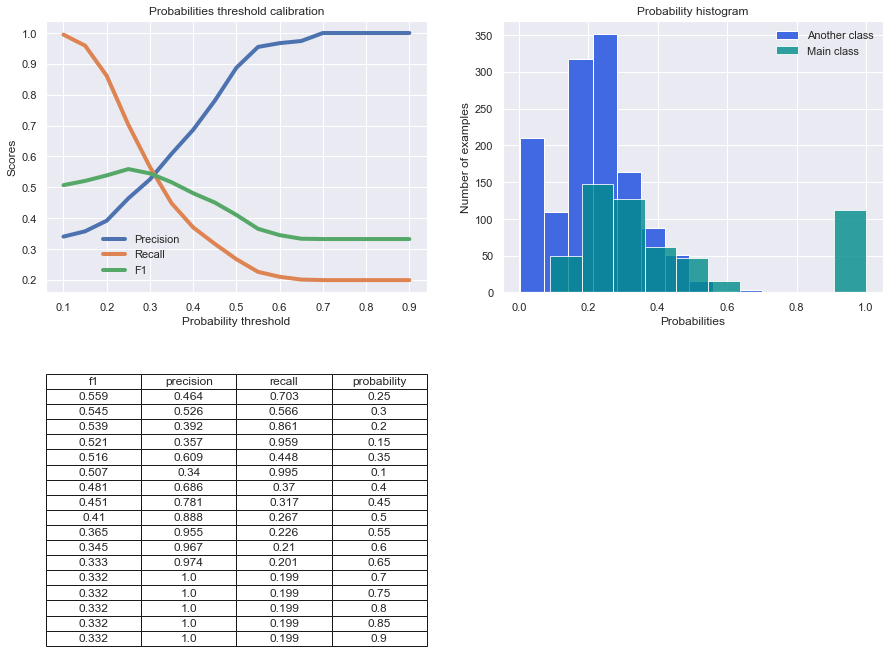

In [718]:
sns.set(font_scale = 1)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Протестируем модель с ограниченным кол-вом признаков:

In [1057]:
len(important_features_top)

20

In [1058]:
X2 = X[important_features_top]

Fold #1
TRAIN

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4298
           1       1.00      0.81      0.90      1702

    accuracy                           0.95      6000
   macro avg       0.97      0.91      0.93      6000
weighted avg       0.95      0.95      0.95      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1089
           1       0.74      0.27      0.40       411

    accuracy                           0.77      1500
   macro avg       0.76      0.62      0.63      1500
weighted avg       0.77      0.77      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1050   39
1                299  112


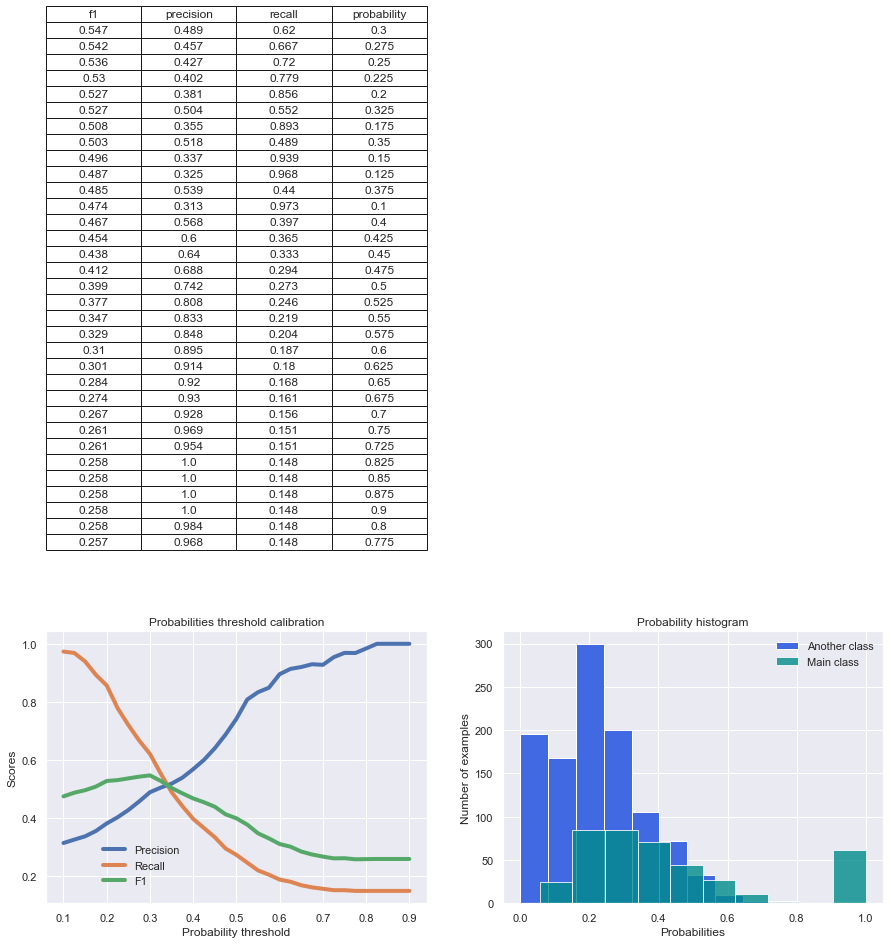

Fold #2
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4326
           1       1.00      0.82      0.90      1674

    accuracy                           0.95      6000
   macro avg       0.97      0.91      0.94      6000
weighted avg       0.95      0.95      0.95      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.85      1061
           1       0.78      0.29      0.42       439

    accuracy                           0.77      1500
   macro avg       0.77      0.63      0.64      1500
weighted avg       0.77      0.77      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1025   36
1                312  127


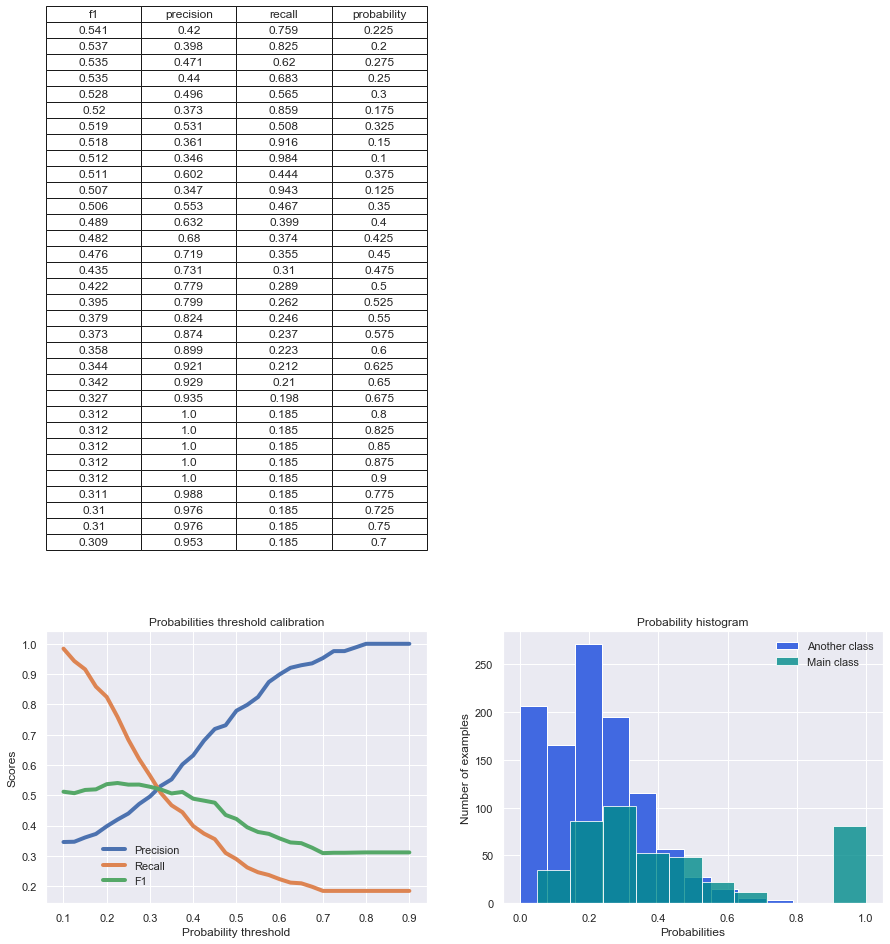

Fold #3
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4287
           1       1.00      0.84      0.91      1713

    accuracy                           0.95      6000
   macro avg       0.97      0.92      0.94      6000
weighted avg       0.96      0.95      0.95      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1100
           1       0.75      0.33      0.46       400

    accuracy                           0.79      1500
   macro avg       0.77      0.65      0.66      1500
weighted avg       0.78      0.79      0.76      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1056   44
1                268  132


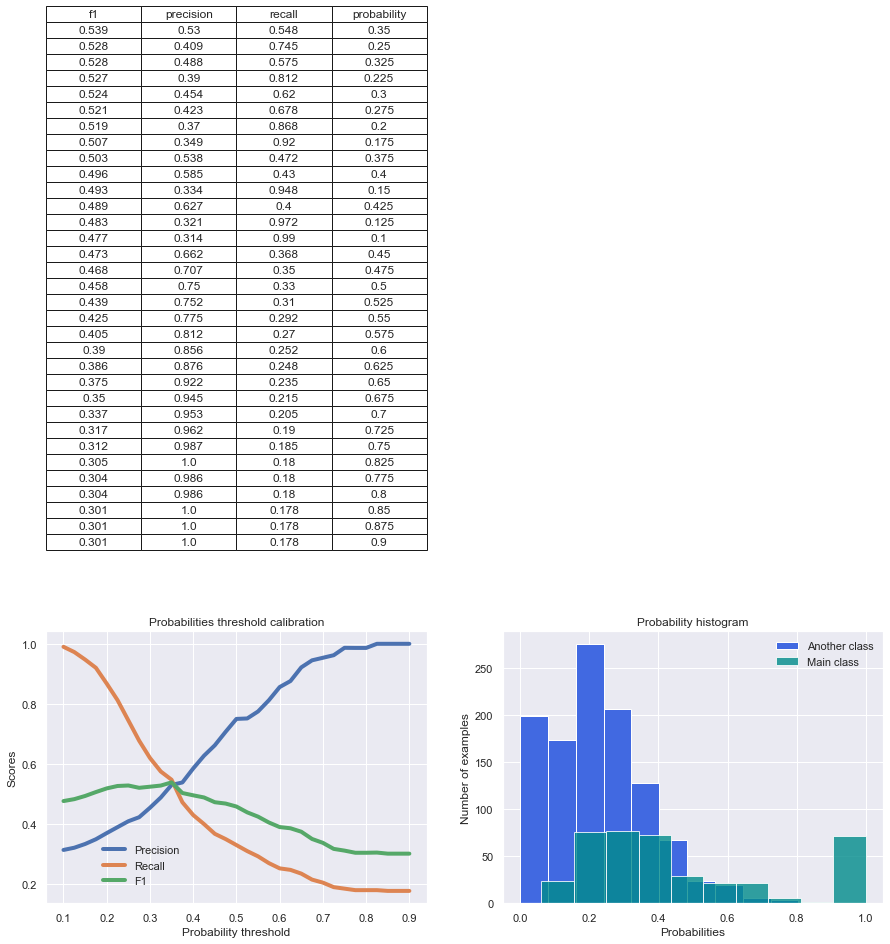

Fold #4
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4297
           1       1.00      0.85      0.92      1703

    accuracy                           0.96      6000
   macro avg       0.97      0.93      0.95      6000
weighted avg       0.96      0.96      0.96      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1090
           1       0.78      0.37      0.50       410

    accuracy                           0.80      1500
   macro avg       0.79      0.66      0.69      1500
weighted avg       0.80      0.80      0.77      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1047   43
1                259  151


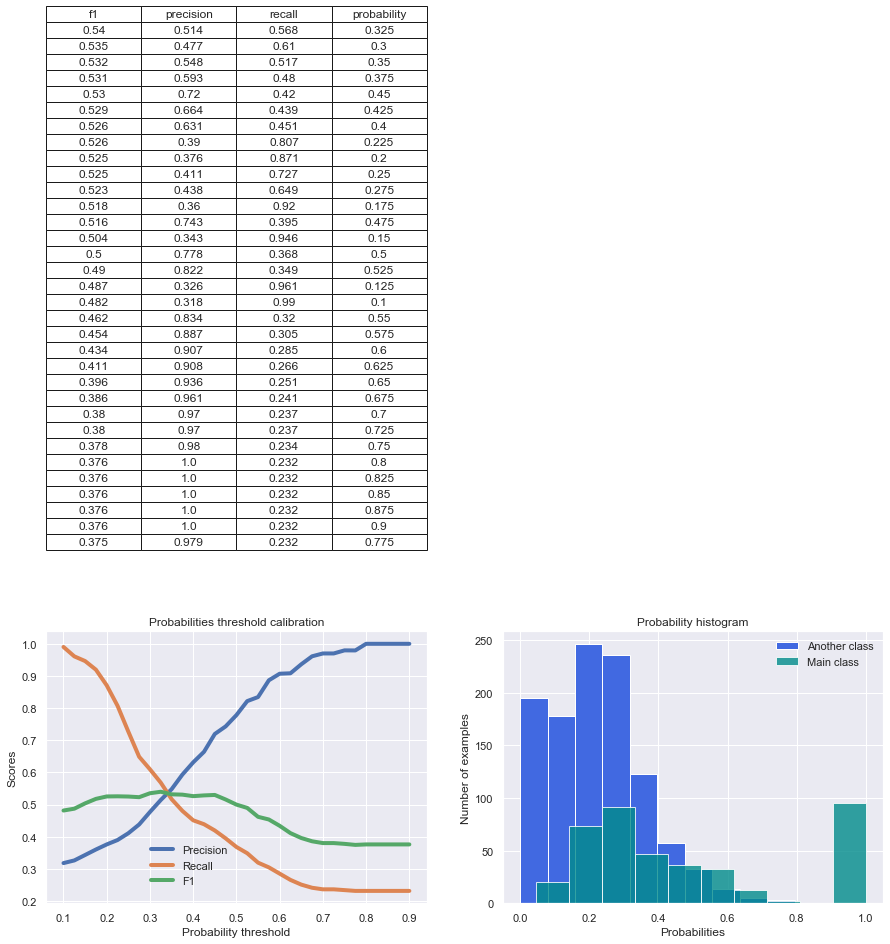

Fold #5
TRAIN

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      4340
           1       1.00      0.81      0.90      1660

    accuracy                           0.95      6000
   macro avg       0.97      0.91      0.93      6000
weighted avg       0.95      0.95      0.95      6000

TEST

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1047
           1       0.77      0.31      0.44       453

    accuracy                           0.76      1500
   macro avg       0.77      0.64      0.65      1500
weighted avg       0.77      0.76      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1006   41
1                312  141


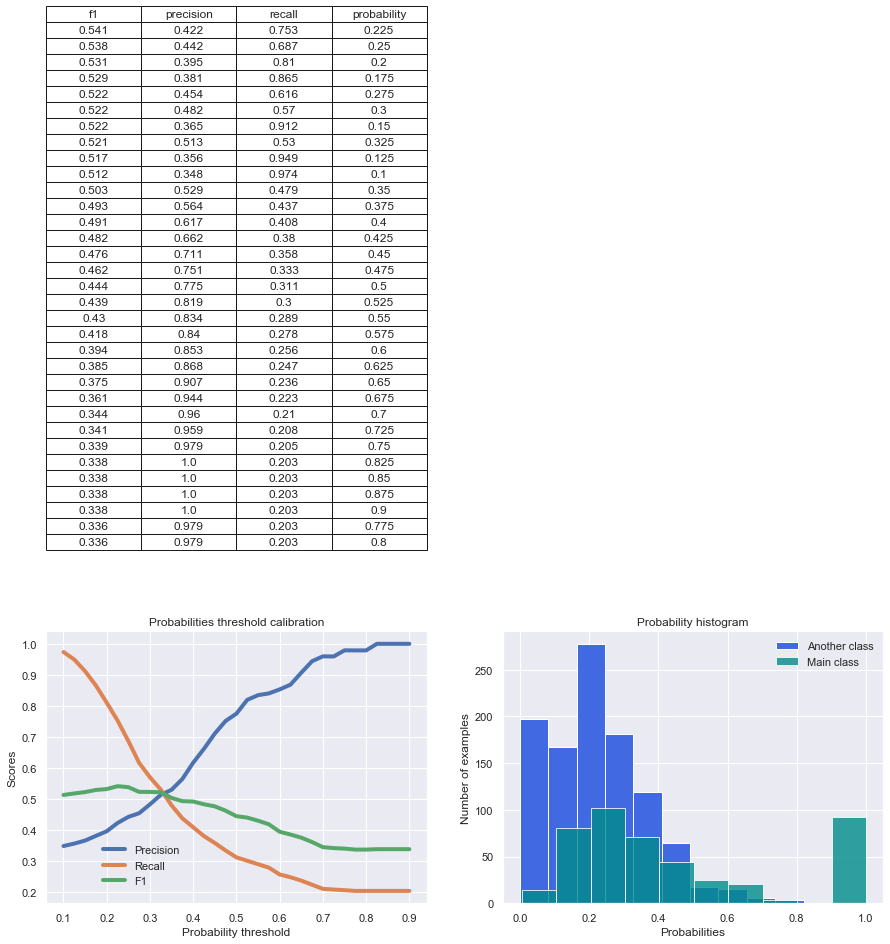

In [1059]:
kf = KFold(n_splits=5)

res_lst = []
for fold, (train_index, test_index) in enumerate(kf.split(X2), 1):
    print(f'Fold #{fold}')
    X_train = X2.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X2.loc[test_index]
    y_test = y.loc[test_index]
    
    
    clf = RandomForestClassifier(max_depth=17, 
                             max_features=14,
                             n_estimators=500, 
                             criterion='entropy'
                            )

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_pred_probs = clf.predict_proba(X_test)

    res_lst.append((clf, y_test_pred_probs, y_test))
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [791]:
#ТОП 20 признаков, добавил признак "Current Loan Amount х2"
#при probability 0.3:
f1 = [0.531, 0.529, 0.534, 0.537, 0.521]
pr = [0.492, 0.507, 0.466, 0.485, 0.49]
re = [0.577, 0.554, 0.625, 0.6, 0.556]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5304
precision 0.4880000000000001
recall 0.5824


In [734]:
#ТОП 20 признаков - лучший результат
#при probability 0.3:
f1 = [0.537, 0.519, 0.559, 0.543, 0.525]
pr = [0.503, 0.518, 0.502, 0.506, 0.513]
re = [0.577, 0.519, 0.63, 0.585, 0.539]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5366000000000001
precision 0.5084
recall 0.5700000000000001


In [729]:
#ТОП 40 признаков - стало хуже
#при probability 0.3:
f1 = [0.534, 0.517, 0.549, 0.547, 0.517]
pr = [0.505, 0.517, 0.493, 0.499, 0.5]
re = [0.567, 0.517, 0.62, 0.588, 0.534]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5328
precision 0.5028
recall 0.5652000000000001


## Протестируем Случайный лес с балансировкой классов

Fold #1
[(0, 4298), (1, 2578)]
TRAIN

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4298
           1       1.00      0.79      0.88      2578

    accuracy                           0.92      6876
   macro avg       0.94      0.89      0.91      6876
weighted avg       0.93      0.92      0.92      6876

TEST

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1089
           1       0.67      0.32      0.44       411

    accuracy                           0.77      1500
   macro avg       0.73      0.63      0.65      1500
weighted avg       0.75      0.77      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1023   66
1                278  133


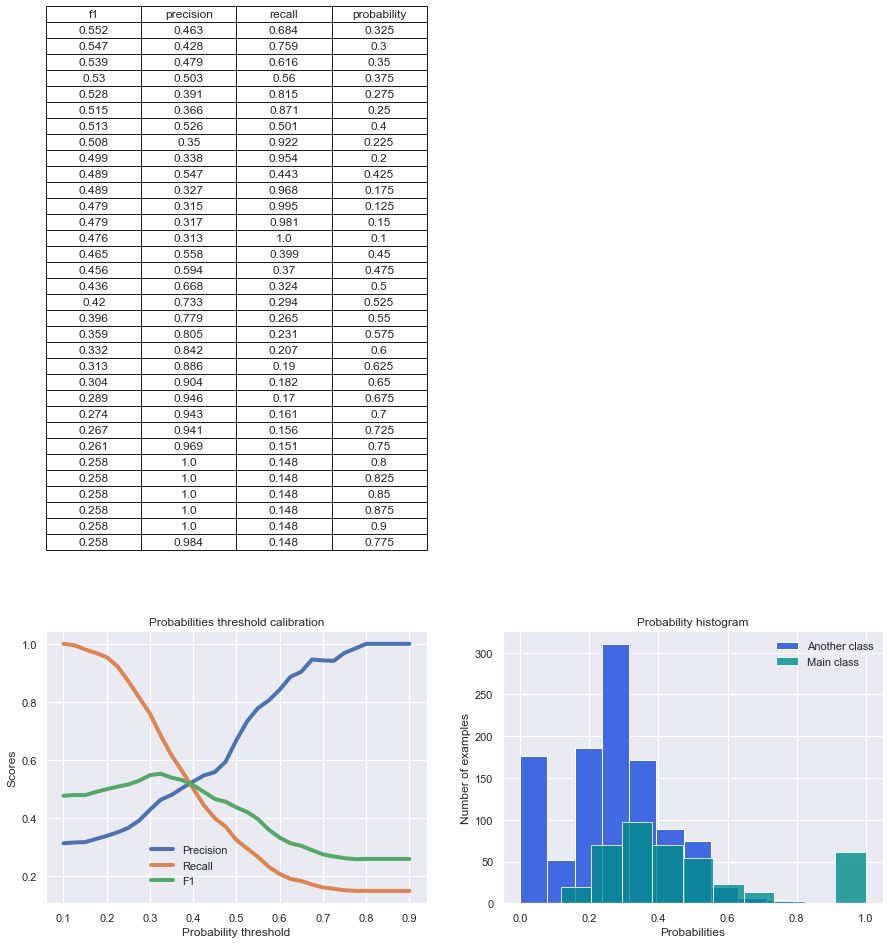

Fold #2
[(0, 4326), (1, 2595)]
TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4326
           1       1.00      0.78      0.87      2595

    accuracy                           0.92      6921
   macro avg       0.94      0.89      0.91      6921
weighted avg       0.93      0.92      0.91      6921

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1061
           1       0.75      0.33      0.46       439

    accuracy                           0.77      1500
   macro avg       0.76      0.64      0.66      1500
weighted avg       0.77      0.77      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1011   50
1                292  147


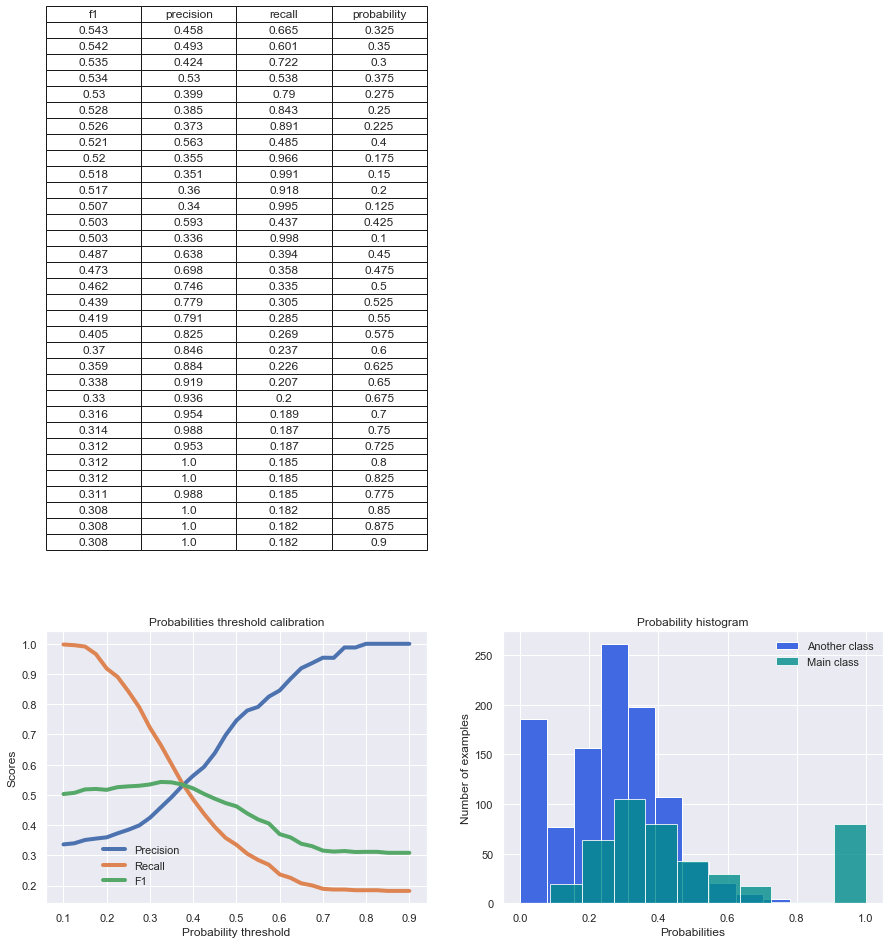

Fold #3
[(0, 4287), (1, 2572)]
TRAIN

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4287
           1       1.00      0.76      0.86      2572

    accuracy                           0.91      6859
   macro avg       0.94      0.88      0.90      6859
weighted avg       0.92      0.91      0.91      6859

TEST

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1100
           1       0.71      0.35      0.47       400

    accuracy                           0.79      1500
   macro avg       0.75      0.65      0.67      1500
weighted avg       0.78      0.79      0.76      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1041   59
1                258  142


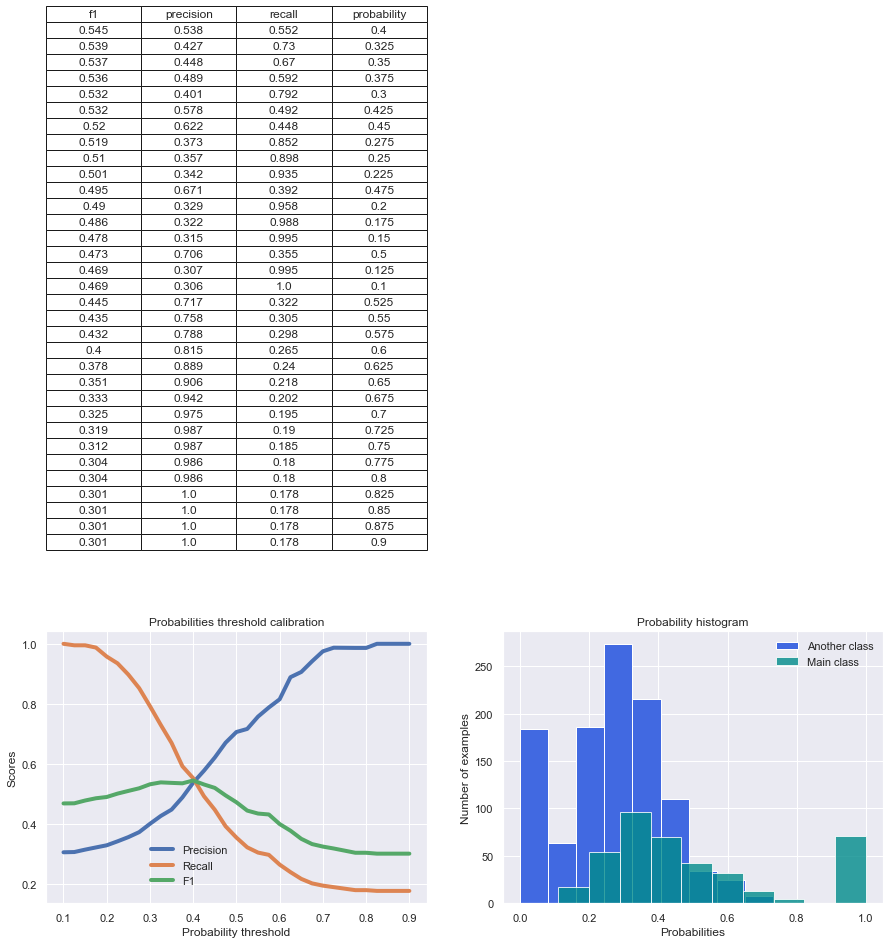

Fold #4
[(0, 4297), (1, 2578)]
TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4297
           1       1.00      0.77      0.87      2578

    accuracy                           0.91      6875
   macro avg       0.94      0.89      0.90      6875
weighted avg       0.92      0.91      0.91      6875

TEST

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1090
           1       0.73      0.40      0.52       410

    accuracy                           0.80      1500
   macro avg       0.77      0.67      0.69      1500
weighted avg       0.79      0.80      0.77      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1029   61
1                245  165


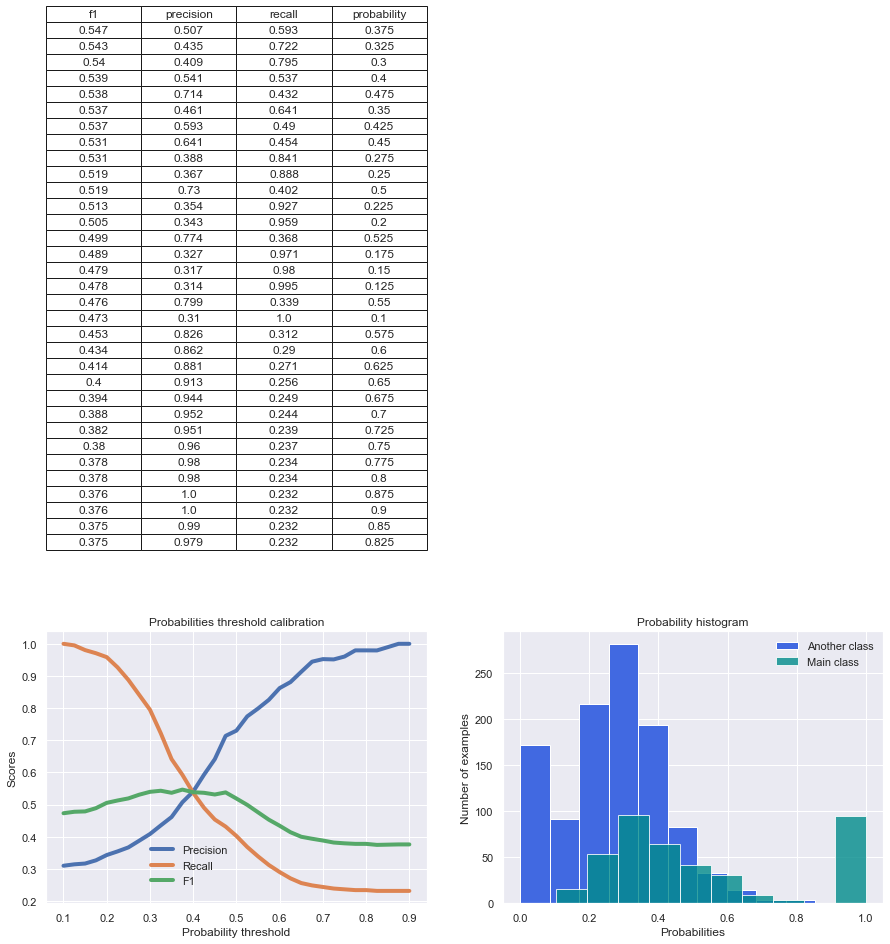

Fold #5
[(0, 4340), (1, 2604)]
TRAIN

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4340
           1       0.99      0.77      0.87      2604

    accuracy                           0.91      6944
   macro avg       0.94      0.88      0.90      6944
weighted avg       0.92      0.91      0.91      6944

TEST

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1047
           1       0.67      0.35      0.46       453

    accuracy                           0.75      1500
   macro avg       0.72      0.64      0.65      1500
weighted avg       0.74      0.75      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               968   79
1               296  157


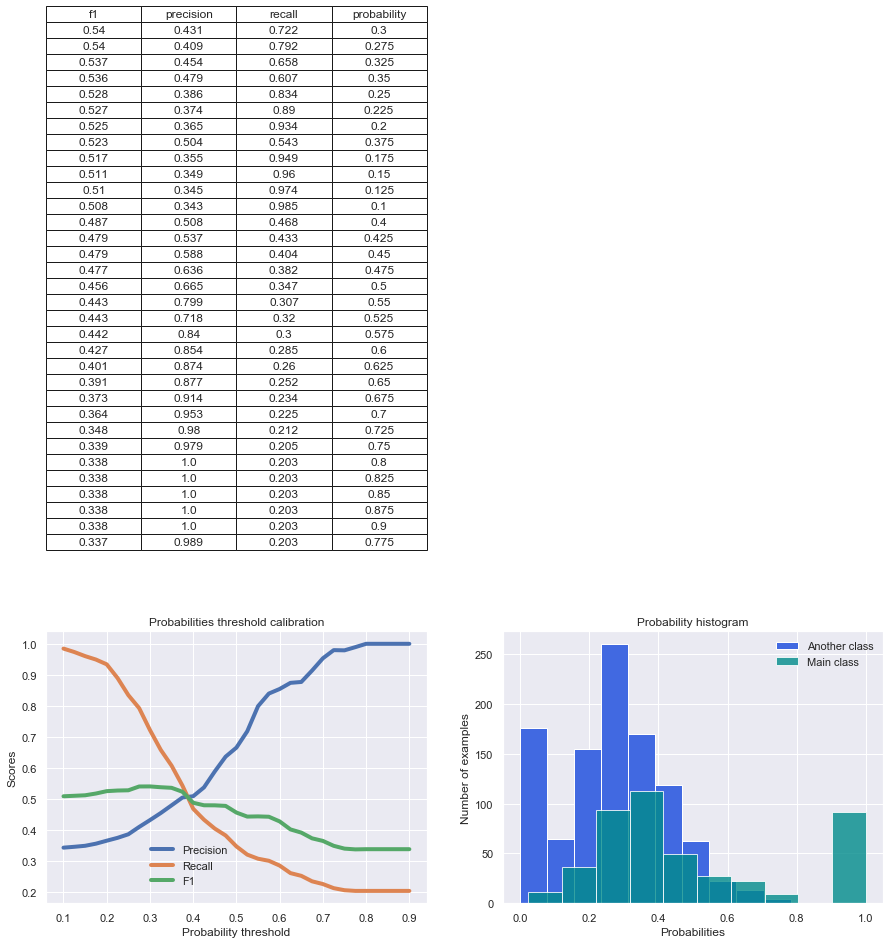

In [1060]:
kf = KFold(n_splits=5)

res_lst = []
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f'Fold #{fold}')
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
    X_train_resampled, y_train_resampled = RandomOverSampler(sampling_strategy=0.6, 
                                                             random_state=48
                                                            ).fit_resample(X_train, y_train)

    
    print(sorted(Counter(y_train_resampled).items()))

    
    clf = RandomForestClassifier(max_depth=14, 
                             max_features=14,
                             n_estimators=500, 
                             criterion='entropy'
                            )

    clf.fit(X_train_resampled, y_train_resampled)

    y_train_pred = clf.predict(X_train_resampled)
    y_test_pred = clf.predict(X_test)
    y_test_pred_probs = clf.predict_proba(X_test)

    res_lst.append((clf, y_test_pred_probs, y_test))
    
    get_classification_report(y_train_resampled, y_train_pred, y_test, y_test_pred)
    show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [739]:
#ТОП 20 признаков с балансировкой RandomOverSampler - результат хуже
#при probability 0.35:
f1 = [0.531, 0.52, 0.534, 0.536, 0.534]
pr = [0.514, 0.527, 0.493, 0.511, 0.509]
re = [0.55, 0.513, 0.582, 0.563, 0.561]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.531
precision 0.5107999999999999
recall 0.5538000000000001


In [737]:
#ТОП 20 признаков с балансировкой BorderlineSMOTE - результат хуже
#при probability 0.35:
f1 = [0.531, 0.518, 0.53, 0.542, 0.523]
pr = [0.505, 0.533, 0.495, 0.523, 0.506]
re = [0.56, 0.503, 0.57, 0.554, 0.541]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5288
precision 0.5124000000000001
recall 0.5456000000000001


## Протестируем Градиентный бустинг

XGBoost

Fold #1
[(0, 4298), (1, 2149)]
TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4298
           1       1.00      0.91      0.95      2149

    accuracy                           0.97      6447
   macro avg       0.98      0.95      0.96      6447
weighted avg       0.97      0.97      0.97      6447

TEST

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1089
           1       0.57      0.36      0.45       411

    accuracy                           0.75      1500
   macro avg       0.68      0.63      0.64      1500
weighted avg       0.73      0.75      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               978  111
1               261  150


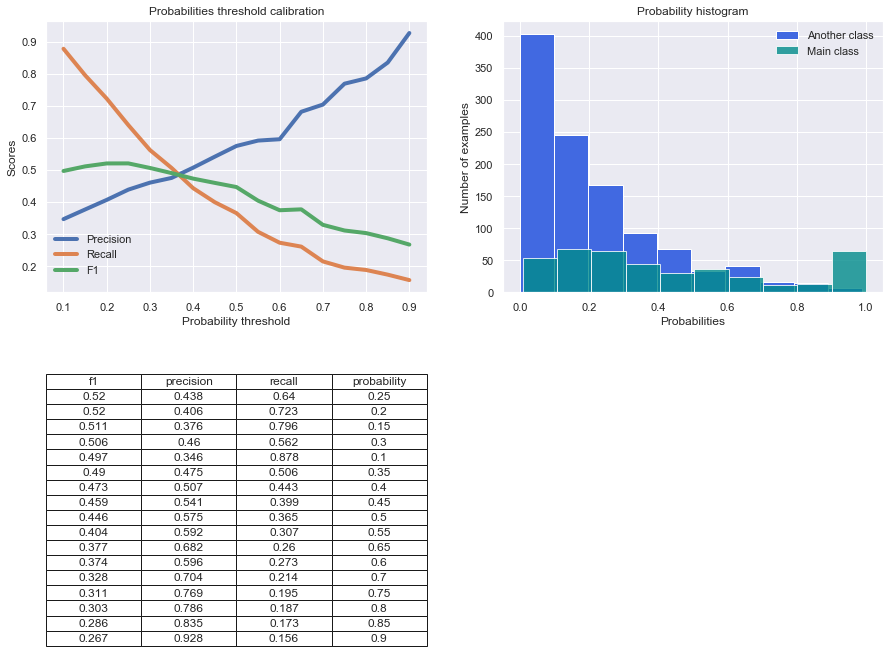

Fold #2
[(0, 4326), (1, 2163)]
TRAIN

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4326
           1       0.99      0.90      0.94      2163

    accuracy                           0.96      6489
   macro avg       0.97      0.95      0.96      6489
weighted avg       0.97      0.96      0.96      6489

TEST

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1061
           1       0.63      0.34      0.45       439

    accuracy                           0.75      1500
   macro avg       0.70      0.63      0.64      1500
weighted avg       0.73      0.75      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               974   87
1               288  151


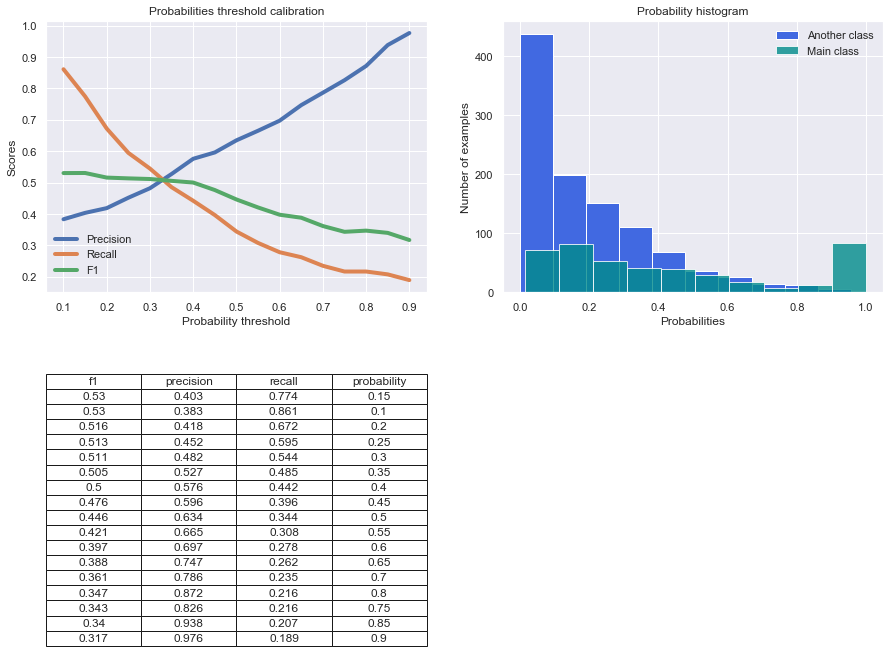

Fold #3
[(0, 4287), (1, 2143)]
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4287
           1       0.99      0.87      0.93      2143

    accuracy                           0.96      6430
   macro avg       0.97      0.94      0.95      6430
weighted avg       0.96      0.96      0.96      6430

TEST

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1100
           1       0.60      0.40      0.48       400

    accuracy                           0.77      1500
   macro avg       0.70      0.65      0.67      1500
weighted avg       0.75      0.77      0.75      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               995  105
1               240  160


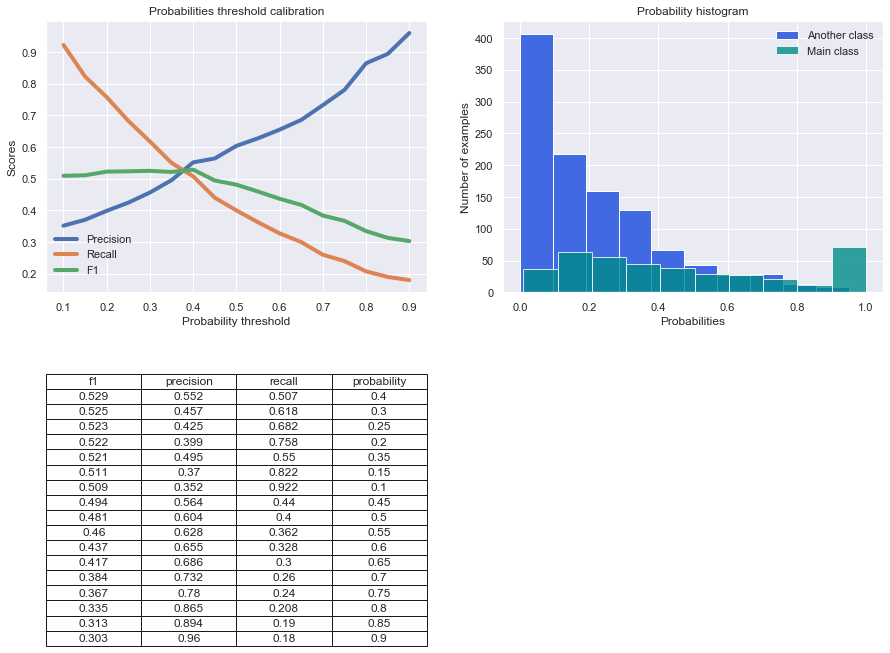

Fold #4
[(0, 4297), (1, 2148)]
TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4297
           1       0.99      0.91      0.95      2148

    accuracy                           0.97      6445
   macro avg       0.97      0.95      0.96      6445
weighted avg       0.97      0.97      0.97      6445

TEST

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1090
           1       0.60      0.43      0.50       410

    accuracy                           0.76      1500
   macro avg       0.70      0.66      0.67      1500
weighted avg       0.75      0.76      0.75      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               970  120
1               233  177


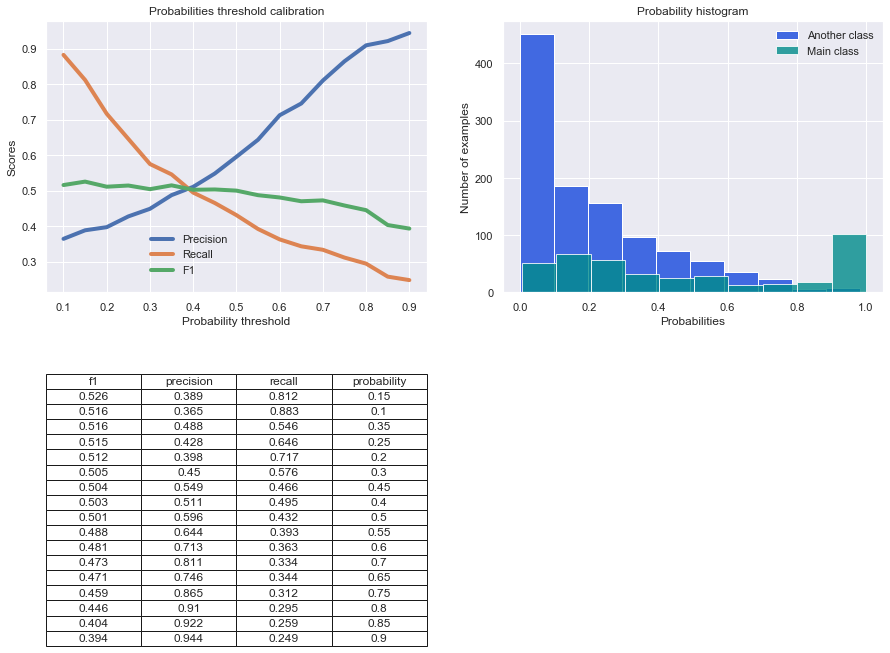

Fold #5
[(0, 4340), (1, 2170)]
TRAIN

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4340
           1       0.99      0.90      0.94      2170

    accuracy                           0.96      6510
   macro avg       0.97      0.95      0.96      6510
weighted avg       0.97      0.96      0.96      6510

TEST

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1047
           1       0.62      0.39      0.48       453

    accuracy                           0.75      1500
   macro avg       0.70      0.65      0.66      1500
weighted avg       0.73      0.75      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               940  107
1               275  178


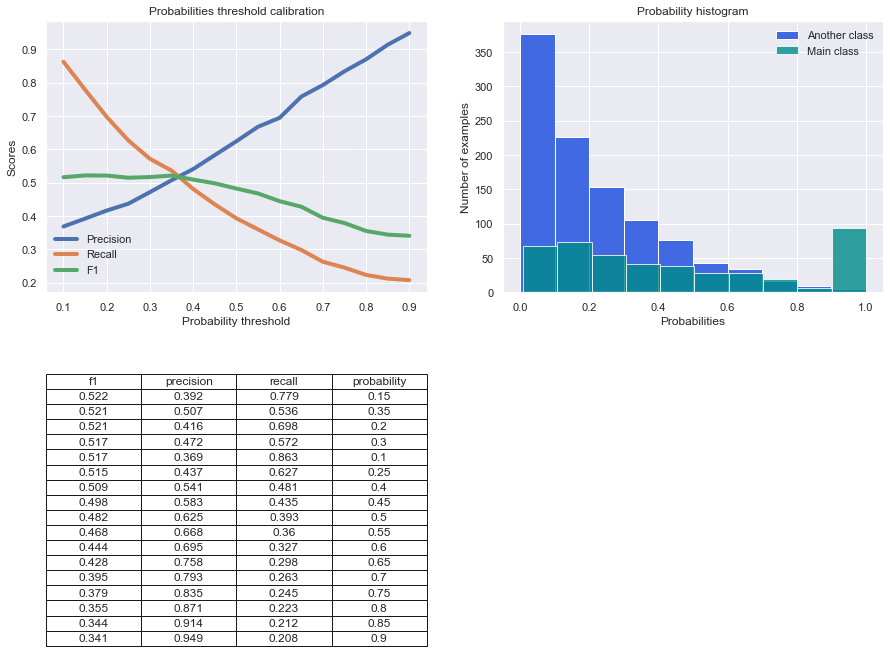

In [760]:
kf = KFold(n_splits=5)

res_lst = []
for fold, (train_index, test_index) in enumerate(kf.split(X2), 1):
    print(f'Fold #{fold}')
    X_train = X2.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X2.loc[test_index]
    y_test = y.loc[test_index]
    
    X_train_resampled, y_train_resampled = BorderlineSMOTE(sampling_strategy=0.5, 
                                                             random_state=48
                                                            ).fit_resample(X_train, y_train)
    print(sorted(Counter(y_train_resampled).items()))

    
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_xgb.fit(X_train_resampled, y_train_resampled)
#     model_xgb.fit(X_train, y_train)
    
    y_train_pred = model_xgb.predict(X_train_resampled)
#     y_train_pred = model_xgb.predict(X_train)

    y_test_pred = model_xgb.predict(X_test)
    y_test_pred_probs = model_xgb.predict_proba(X_test)

    res_lst.append((model_xgb, y_test_pred_probs, y_test))
    
    get_classification_report(y_train_resampled, y_train_pred, y_test, y_test_pred)
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

результаты слабые, что с балансировкой, что без

LightGBM

Fold #1
[(0, 4298), (1, 2149)]
TRAIN

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4298
           1       0.98      0.73      0.84      2149

    accuracy                           0.90      6447
   macro avg       0.93      0.86      0.88      6447
weighted avg       0.91      0.90      0.90      6447

TEST

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1089
           1       0.61      0.36      0.46       411

    accuracy                           0.76      1500
   macro avg       0.70      0.64      0.65      1500
weighted avg       0.74      0.76      0.74      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               995   94
1               261  150


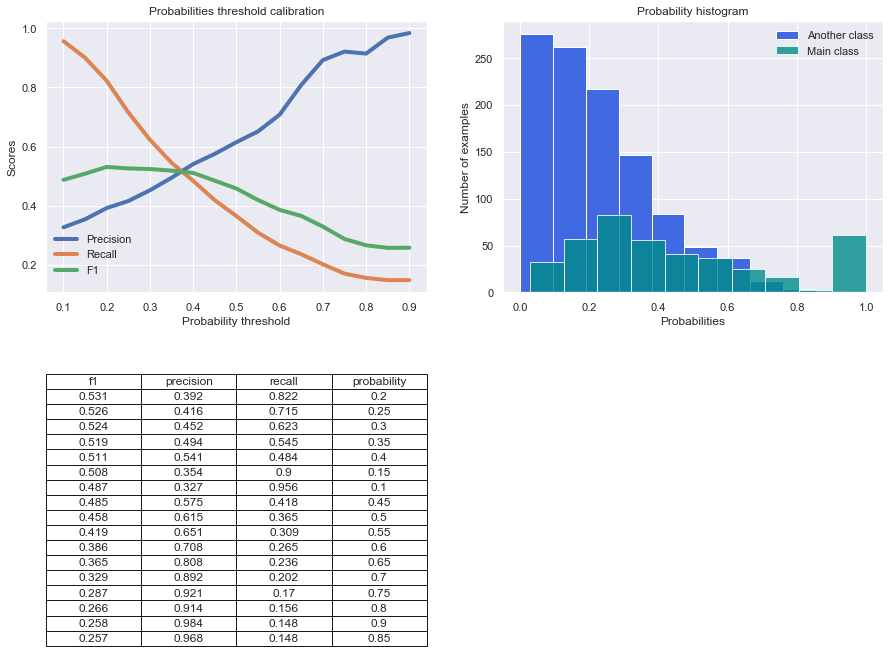

Fold #2
[(0, 4326), (1, 2163)]
TRAIN

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4326
           1       0.97      0.72      0.83      2163

    accuracy                           0.90      6489
   macro avg       0.92      0.86      0.88      6489
weighted avg       0.91      0.90      0.90      6489

TEST

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1061
           1       0.69      0.33      0.45       439

    accuracy                           0.76      1500
   macro avg       0.73      0.63      0.65      1500
weighted avg       0.75      0.76      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               994   67
1               293  146


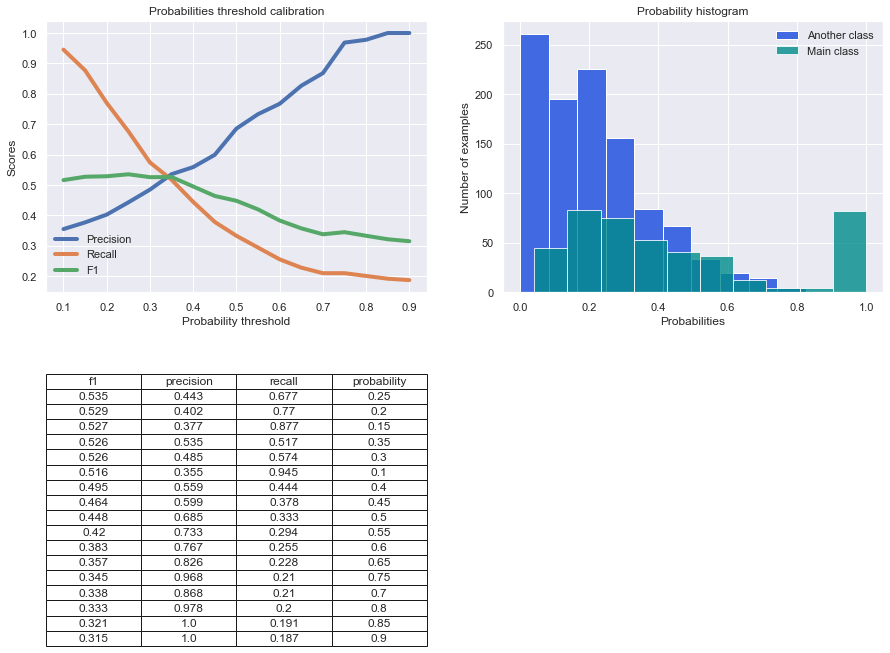

Fold #3
[(0, 4287), (1, 2143)]
TRAIN

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      4287
           1       0.97      0.72      0.82      2143

    accuracy                           0.90      6430
   macro avg       0.92      0.85      0.88      6430
weighted avg       0.91      0.90      0.89      6430

TEST

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1100
           1       0.63      0.38      0.48       400

    accuracy                           0.78      1500
   macro avg       0.72      0.65      0.67      1500
weighted avg       0.76      0.78      0.76      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1012   88
1                247  153


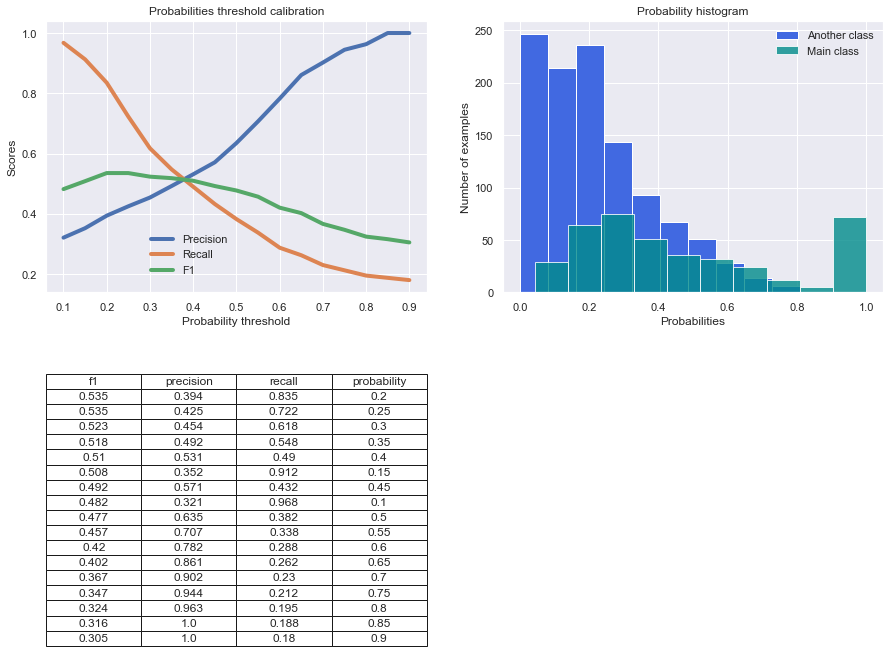

Fold #4
[(0, 4297), (1, 2148)]
TRAIN

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4297
           1       0.97      0.72      0.83      2148

    accuracy                           0.90      6445
   macro avg       0.92      0.85      0.88      6445
weighted avg       0.91      0.90      0.90      6445

TEST

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1090
           1       0.69      0.40      0.51       410

    accuracy                           0.79      1500
   macro avg       0.75      0.67      0.69      1500
weighted avg       0.77      0.79      0.77      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1017   73
1                246  164


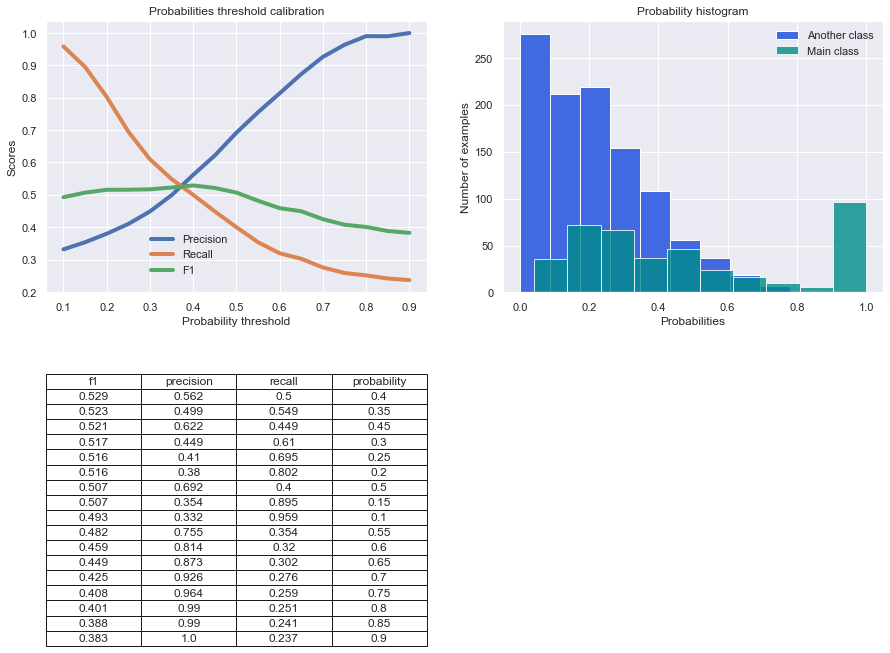

Fold #5
[(0, 4340), (1, 2170)]
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      4340
           1       0.97      0.75      0.84      2170

    accuracy                           0.91      6510
   macro avg       0.93      0.87      0.89      6510
weighted avg       0.91      0.91      0.90      6510

TEST

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1047
           1       0.68      0.35      0.47       453

    accuracy                           0.75      1500
   macro avg       0.72      0.64      0.65      1500
weighted avg       0.74      0.75      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               972   75
1               293  160


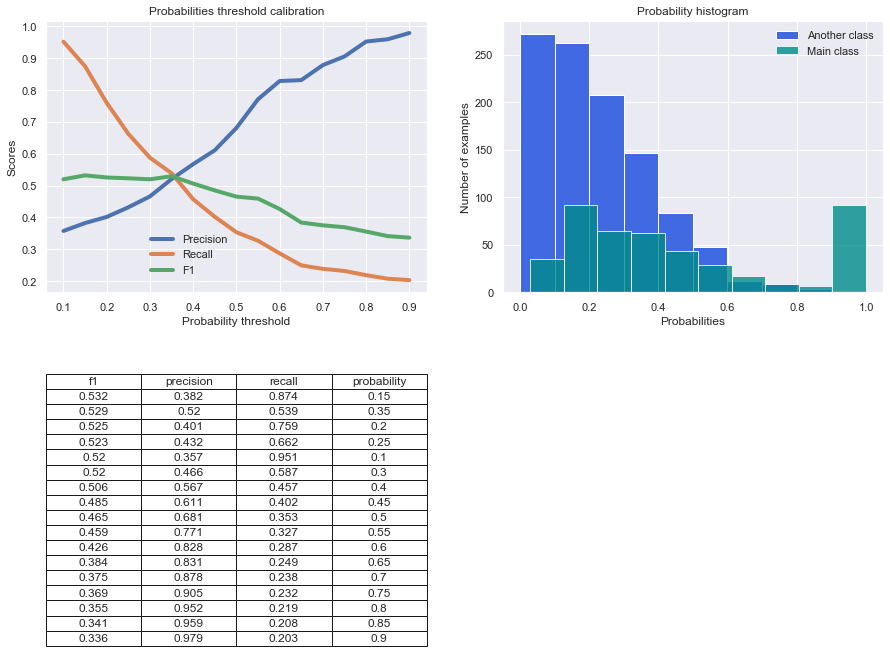

In [761]:
kf = KFold(n_splits=5)

res_lst = []
for fold, (train_index, test_index) in enumerate(kf.split(X2), 1):
    print(f'Fold #{fold}')
    X_train = X2.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X2.loc[test_index]
    y_test = y.loc[test_index]
    
    X_train_resampled, y_train_resampled = BorderlineSMOTE(sampling_strategy=0.5, 
                                                             random_state=48
                                                            ).fit_resample(X_train, y_train)
    print(sorted(Counter(y_train_resampled).items()))

    
    model_lgbm = lgbm.LGBMClassifier(random_state=21, l2_leaf_reg=10,)
    model_lgbm.fit(X_train_resampled, y_train_resampled)
#     model_lgbm.fit(X_train, y_train)
    
    y_train_pred = model_lgbm.predict(X_train_resampled)
#     y_train_pred = model_lgbm.predict(X_train)

    y_test_pred = model_lgbm.predict(X_test)
    y_test_pred_probs = model_lgbm.predict_proba(X_test)

    res_lst.append((model_lgbm, y_test_pred_probs, y_test))
    
    get_classification_report(y_train_resampled, y_train_pred, y_test, y_test_pred)
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

результаты слабые, что с балансировкой, что без

CatBoost

Fold #1
TRAIN

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4298
           1       0.98      0.53      0.69      1702

    accuracy                           0.86      6000
   macro avg       0.91      0.76      0.80      6000
weighted avg       0.88      0.86      0.85      6000

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1089
           1       0.70      0.28      0.40       411

    accuracy                           0.77      1500
   macro avg       0.74      0.62      0.63      1500
weighted avg       0.76      0.77      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1040   49
1                295  116


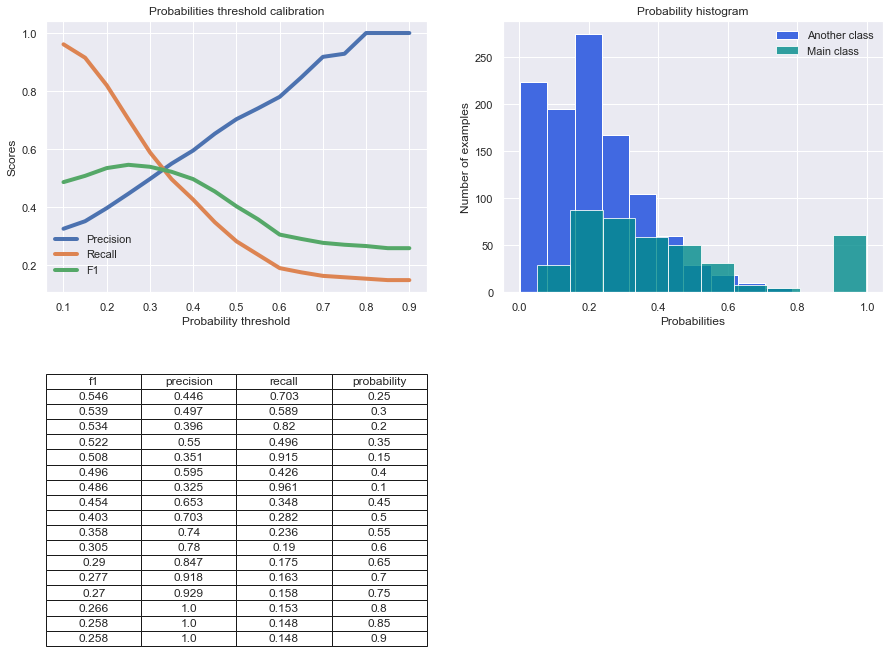

Fold #2
TRAIN

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4326
           1       0.96      0.52      0.68      1674

    accuracy                           0.86      6000
   macro avg       0.90      0.76      0.79      6000
weighted avg       0.88      0.86      0.85      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1061
           1       0.75      0.29      0.42       439

    accuracy                           0.76      1500
   macro avg       0.76      0.62      0.63      1500
weighted avg       0.76      0.76      0.72      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1020   41
1                313  126


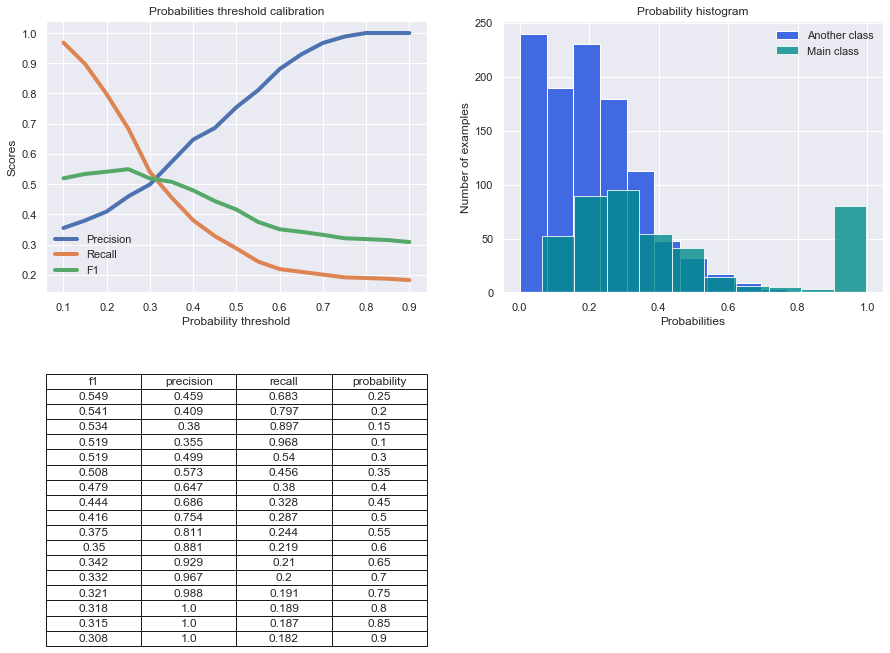

Fold #3
TRAIN

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4287
           1       0.95      0.52      0.67      1713

    accuracy                           0.86      6000
   macro avg       0.90      0.76      0.79      6000
weighted avg       0.87      0.86      0.84      6000

TEST

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1100
           1       0.69      0.32      0.43       400

    accuracy                           0.78      1500
   macro avg       0.74      0.63      0.65      1500
weighted avg       0.77      0.78      0.75      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1043   57
1                273  127


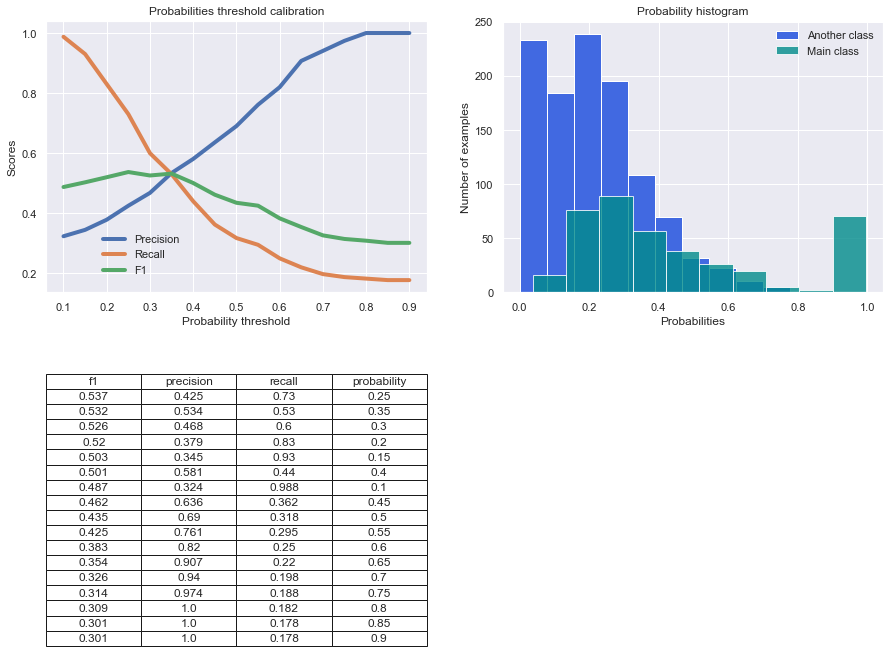

Fold #4
TRAIN

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4297
           1       0.97      0.52      0.68      1703

    accuracy                           0.86      6000
   macro avg       0.90      0.76      0.80      6000
weighted avg       0.88      0.86      0.84      6000

TEST

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1090
           1       0.76      0.36      0.49       410

    accuracy                           0.79      1500
   macro avg       0.78      0.66      0.68      1500
weighted avg       0.79      0.79      0.77      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1043   47
1                261  149


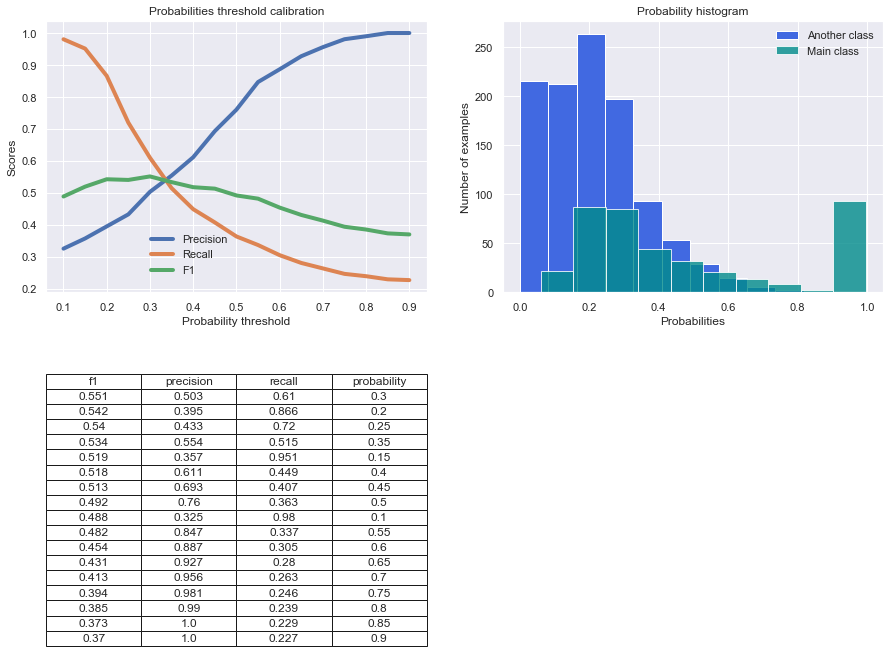

Fold #5
TRAIN

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      4340
           1       0.96      0.54      0.69      1660

    accuracy                           0.87      6000
   macro avg       0.91      0.77      0.80      6000
weighted avg       0.88      0.87      0.85      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1047
           1       0.80      0.32      0.46       453

    accuracy                           0.77      1500
   macro avg       0.78      0.64      0.66      1500
weighted avg       0.78      0.77      0.74      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1010   37
1                307  146


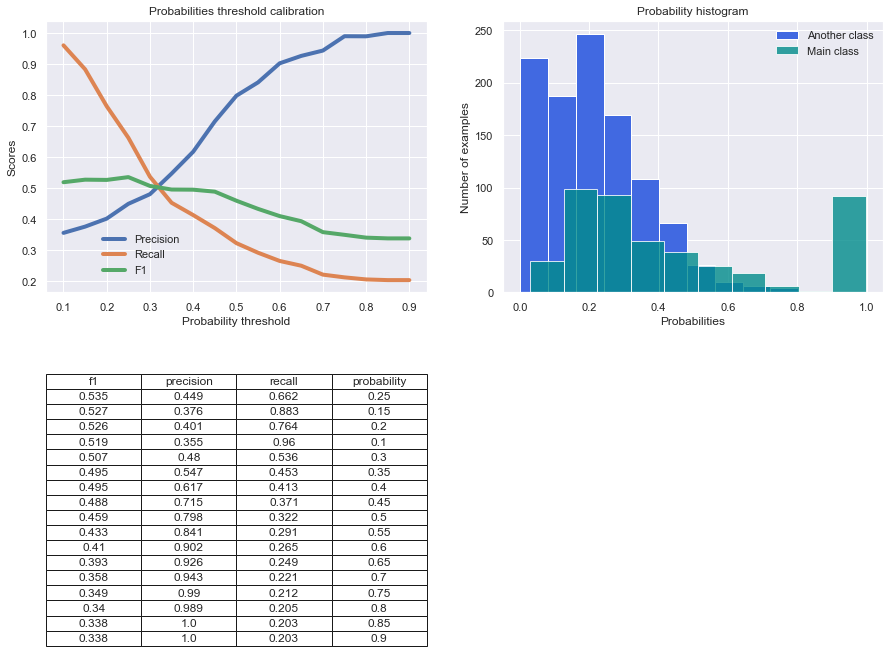

In [757]:
kf = KFold(n_splits=5)

res_lst = []
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f'Fold #{fold}')
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
#     X_train_resampled, y_train_resampled = BorderlineSMOTE(sampling_strategy=0.5, 
#                                                              random_state=48
#                                                             ).fit_resample(X_train, y_train)
#     print(sorted(Counter(y_train_resampled).items()))

    
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
#     model_catb.fit(X_train_resampled, y_train_resampled)
    model_catb.fit(X_train, y_train)
    
#     y_train_pred = model_catb.predict(X_train_resampled)
    y_train_pred = model_catb.predict(X_train)
    y_test_pred = model_catb.predict(X_test)
    y_test_pred_probs = model_catb.predict_proba(X_test)

    res_lst.append((model_catb, y_test_pred_probs, y_test))
    
#     get_classification_report(y_train_resampled, y_train_pred, y_test, y_test_pred)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [752]:
#ТОП 20 признаков с балансировкой BorderlineSMOTE - результат хуже
#при probability 0.35:
f1 = [0.543, 0.529, 0.538, 0.529, 0.504]
pr = [0.529, 0.563, 0.514, 0.517, 0.502]
re = [0.557, 0.499, 0.565, 0.541, 0.506]
print('f1', np.mean(f1))
print('precision', np.mean(pr))
print('recall', np.mean(re))

f1 0.5286000000000001
precision 0.525
recall 0.5336000000000001


Подбор параметров для Catboost

In [896]:
y = df_final[target_feat]
X = df_final.drop(target_feat, axis=1)
y = df_final[target_feat]

In [897]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [898]:
cat_feat = ['Home Ownership', 'Purpose', 'Term_Year', 'Term_Home']

In [899]:
params = {'n_estimators':[200, 300], 
          'max_depth':[15, 18],
          'l2_leaf_reg': [1, 5, 10],
          'learning_rate':[0.05, 0.1, 0.2],
         }

In [900]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [901]:
%%time

# rs = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train, cat_features=cat_feat)

Wall time: 2h 40min 46s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000026D2F3AB1C8>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [1, 5, 10],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [15, 18], 'n_estimators': [200, 300]},
             scoring='f1')

In [902]:
# rs.best_params_

{'l2_leaf_reg': 10, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300}

In [905]:
%%time

# final_model = catb.CatBoostClassifier(n_estimators=300, max_depth=15, learning_rate=0.1,
#                                       silent=True, random_state=21, l2_leaf_reg=10)
# final_model.fit(X_train, y_train, cat_features=cat_feat)

# y_train_pred = final_model.predict(X_train)
# y_test_pred = final_model.predict(X_test)
# y_test_pred_probs = final_model.predict_proba(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4074
           1       1.00      0.94      0.97      1551

    accuracy                           0.98      5625
   macro avg       0.99      0.97      0.98      5625
weighted avg       0.98      0.98      0.98      5625

TEST

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1313
           1       0.69      0.30      0.42       562

    accuracy                           0.75      1875
   macro avg       0.73      0.62      0.63      1875
weighted avg       0.74      0.75      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1238   75
1                393  169
Wall time: 4min 15s


In [906]:
# y_test_pred_probs = final_model.predict_proba(X_test)

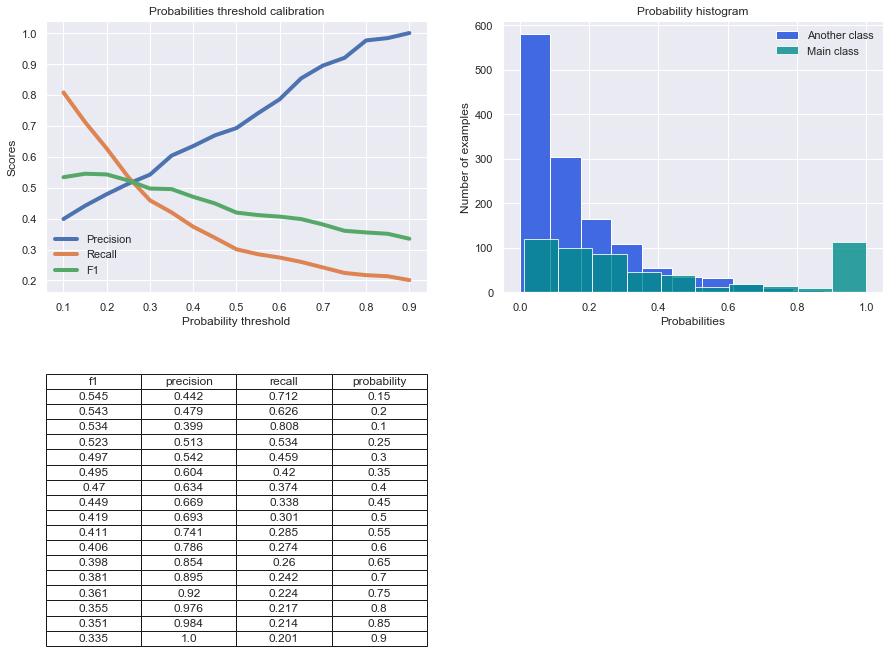

In [907]:
# show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)